# MLII - Time Series - Energy Demand

## Set up

In [1]:
# Import train & test data 

import numpy as np
import pandas as pd

df_train_raw = pd.read_csv("power_market(1).csv", parse_dates=True)
df_scoring = pd.read_csv("scoring.csv",parse_dates=True)

df_train_raw['df_train'] = 1
df_scoring['df_train'] = 0

## Data Cleaning

In [2]:
# checking for null in df_train

df_train_raw.isnull().sum()

fc_demand       0
fc_nuclear      0
import_FR      13
export_FR      13
fc_wind         0
fc_solar_pv     0
fc_solar_th     0
price           0
date            0
hour            0
df_train        0
dtype: int64

In [3]:
# Removing null values in df_train by imputing with the daily mean

df_train_raw['import_FR'] = df_train_raw['import_FR'].fillna(df_train_raw.groupby('date')['import_FR'].transform('mean'))
df_train_raw['export_FR'] = df_train_raw['export_FR'].fillna(df_train_raw.groupby('date')['export_FR'].transform('mean'))

In [4]:
# checking for null in df_scoring

df_scoring.isnull().sum()

fc_demand      0
fc_nuclear     0
import_FR      0
export_FR      0
fc_wind        0
fc_solar_pv    0
fc_solar_th    0
date           0
hour           0
df_train       0
dtype: int64

In [5]:
# combining both datasets into one

all_data = pd.concat([df_train_raw,df_scoring])

In [6]:
# showing data types
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35808 entries, 0 to 3672
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fc_demand    35808 non-null  float64
 1   fc_nuclear   35808 non-null  float64
 2   import_FR    35808 non-null  float64
 3   export_FR    35808 non-null  float64
 4   fc_wind      35808 non-null  float64
 5   fc_solar_pv  35808 non-null  float64
 6   fc_solar_th  35808 non-null  float64
 7   price        32135 non-null  float64
 8   date         35808 non-null  object 
 9   hour         35808 non-null  int64  
 10  df_train     35808 non-null  int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 3.3+ MB


In [1]:
# Setting date to date type
all_data.loc[:,'date'] =  pd.to_datetime(all_data.loc[:,'date'], format='%Y-%m-%d')

# Creating date_time by combining date and hour
all_data.loc[:,'date_time'] = pd.to_datetime(all_data.date) + all_data.hour.astype('timedelta64[h]')

NameError: name 'pd' is not defined

In [8]:
all_data.head()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24400.0      7117.2     3000.0     2600.0   1732.0          0.0   
1    23616.0      7117.2     3000.0     2650.0   1826.0          0.0   
2    21893.0      7117.2     3000.0     2650.0   1823.0          0.0   
3    20693.0      7117.2     3000.0     2650.0   1777.0          0.0   
4    19599.0      7117.2     3000.0     2650.0   1746.0          0.0   

   fc_solar_th  price       date  hour  df_train           date_time  
0          5.1  58.82 2017-01-01     0         1 2017-01-01 00:00:00  
1          0.6  58.23 2017-01-01     1         1 2017-01-01 01:00:00  
2          4.6  51.95 2017-01-01     2         1 2017-01-01 02:00:00  
3          9.7  47.27 2017-01-01     3         1 2017-01-01 03:00:00  
4         24.1  45.49 2017-01-01     4         1 2017-01-01 04:00:00

In [9]:
# Checking for duplicates

from collections import defaultdict
D = defaultdict(list)
for i,item in enumerate(all_data.date_time):
    D[item].append(i)
D = {k:v for k,v in D.items() if len(v)>1}
D

{Timestamp('2017-10-29 02:00:00'): [7225, 7226],
 Timestamp('2018-10-28 02:00:00'): [15961, 15962],
 Timestamp('2019-10-27 02:00:00'): [24697, 24698],
 Timestamp('2020-10-25 02:00:00'): [33433, 33434]}

In [10]:
# showing 1 of the duplicates
# The duplicates are not duplicate rows bu instead are the result of daylight saving time. 
# We decide to drop the rows anyway because later on, if we create 24h lag variables their 
# presence will be an issue as not all days will be 24h long.

all_data[all_data.loc[:,'date_time']=='2019-10-27 02:00:00'] 

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
24697    19927.0      6111.4     2050.0     2500.0   3204.0          0.0   
24698    19983.0      6111.4     2050.0     2500.0   2781.0          0.0   

       fc_solar_th  price       date  hour  df_train           date_time  
24697         11.5  42.81 2019-10-27     2         1 2019-10-27 02:00:00  
24698          9.7  42.95 2019-10-27     2         1 2019-10-27 02:00:00

In [11]:
# Droping duplicates (in multiple steps because new duplicates found after running each code block)

all_data = all_data.drop(all_data.index[7226])
all_data = all_data.drop(all_data.index[15962])
all_data = all_data.drop(all_data.index[24698])
all_data = all_data.drop(all_data.index[33434])

In [12]:
all_data = all_data.drop(all_data.index[15960])
all_data = all_data.drop(all_data.index[24695])
all_data = all_data.drop(all_data.index[33430])

In [13]:
all_data = all_data.drop(all_data.index[24693])
all_data = all_data.drop(all_data.index[33427])

In [14]:
all_data = all_data.drop(all_data.index[33425])

## Visualization

In [15]:
# temporarily spliting all_data to plot df_train

df_train = all_data[all_data.loc[:,'df_train',] == 1]
df_scoring = all_data[all_data.loc[:,'df_train'] == 0]

### Checking seasonality and trends

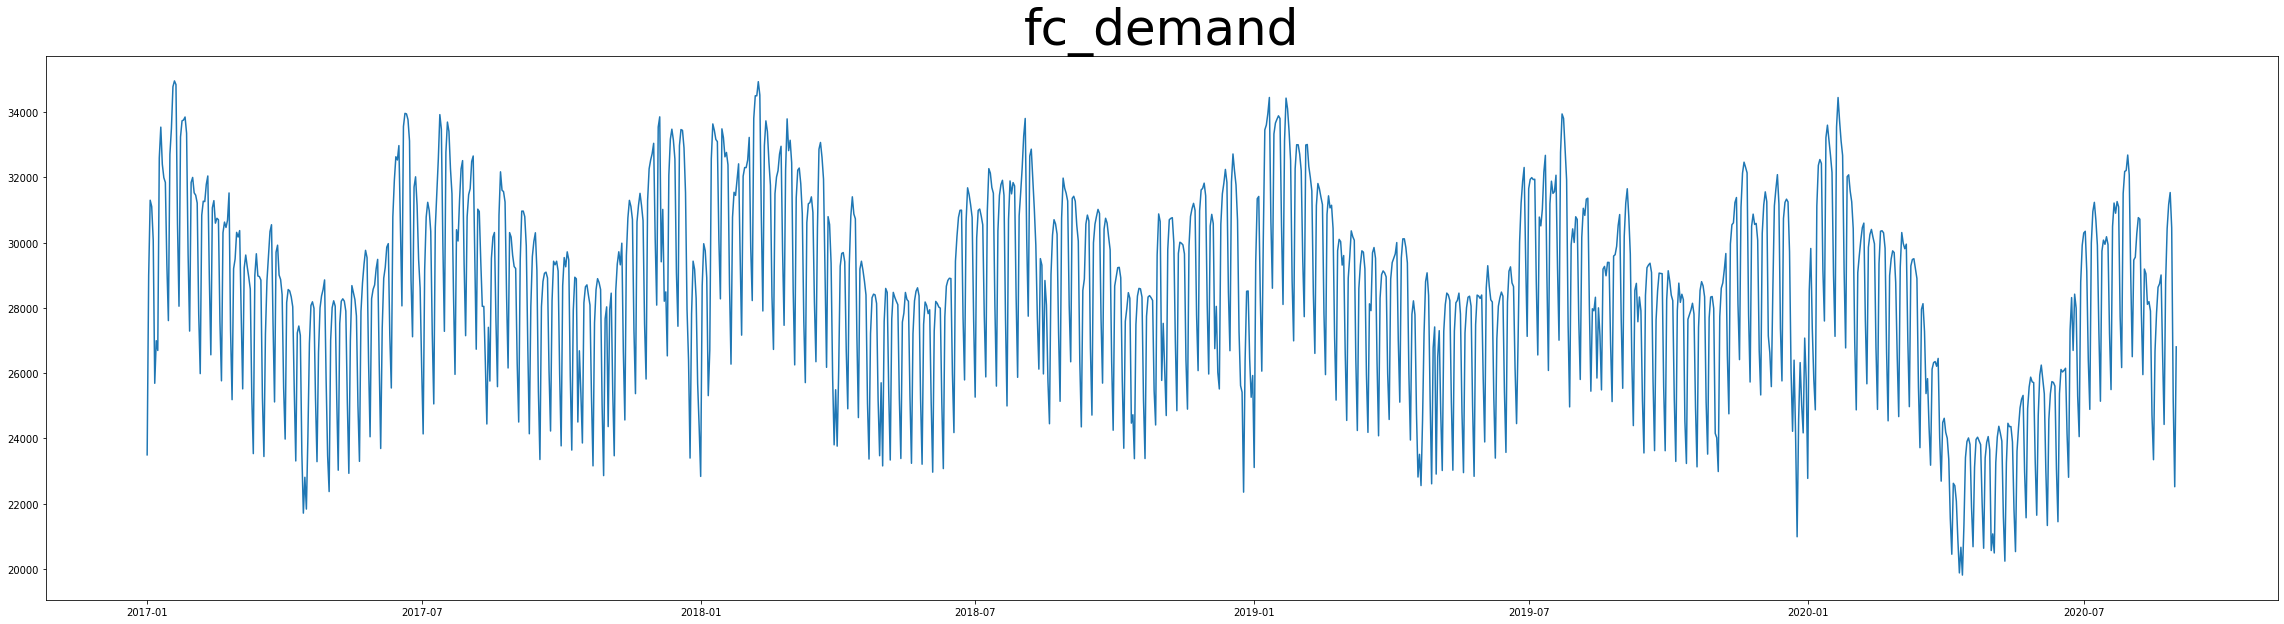

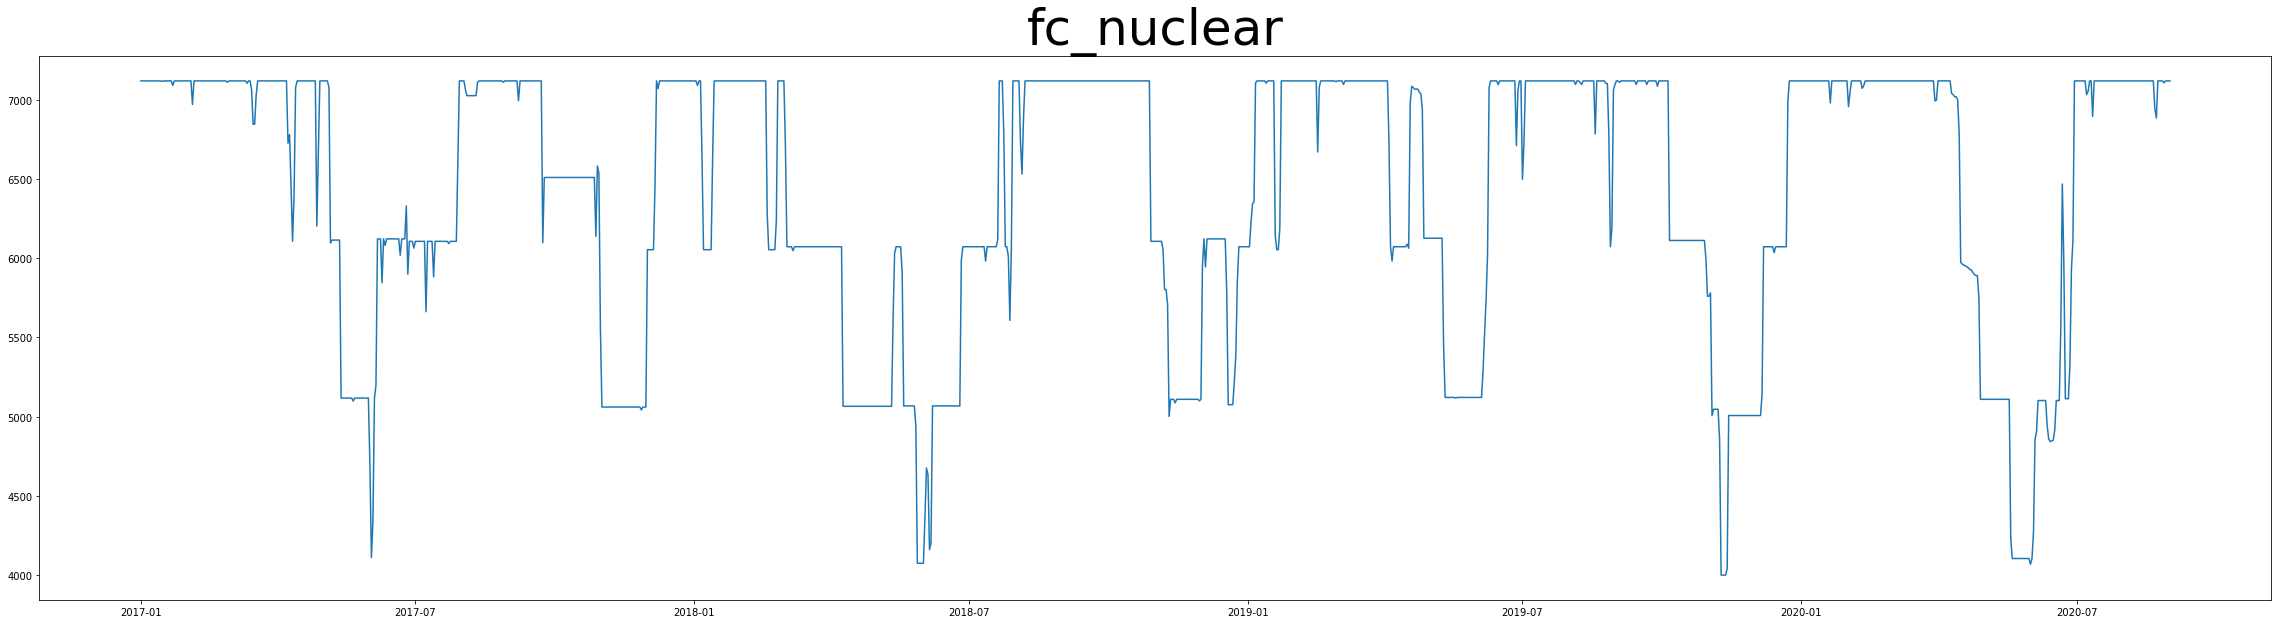

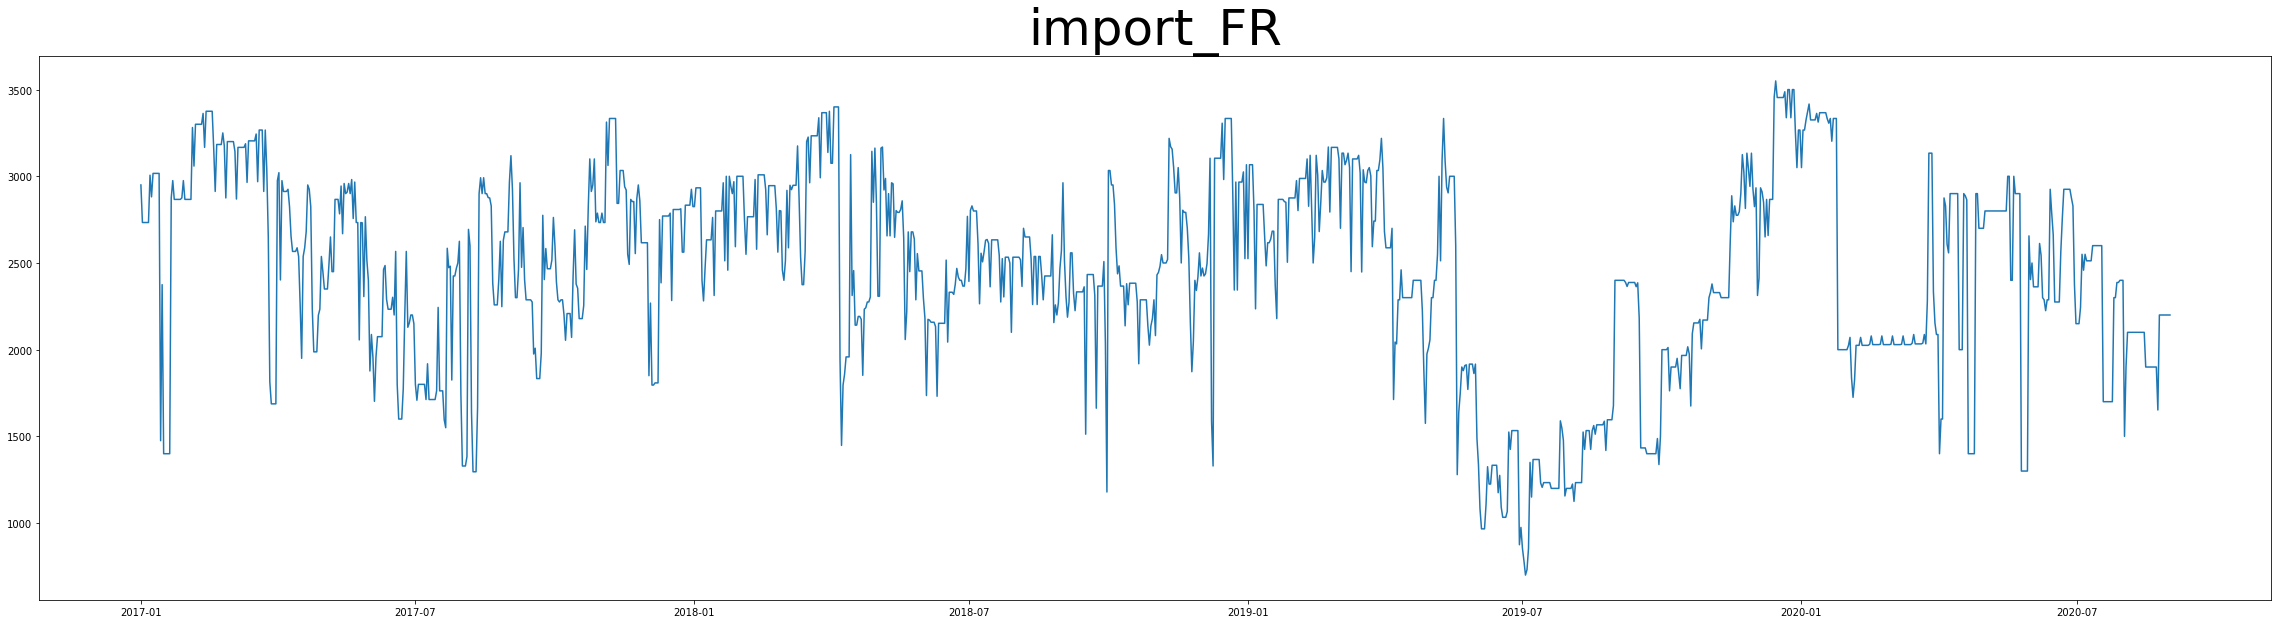

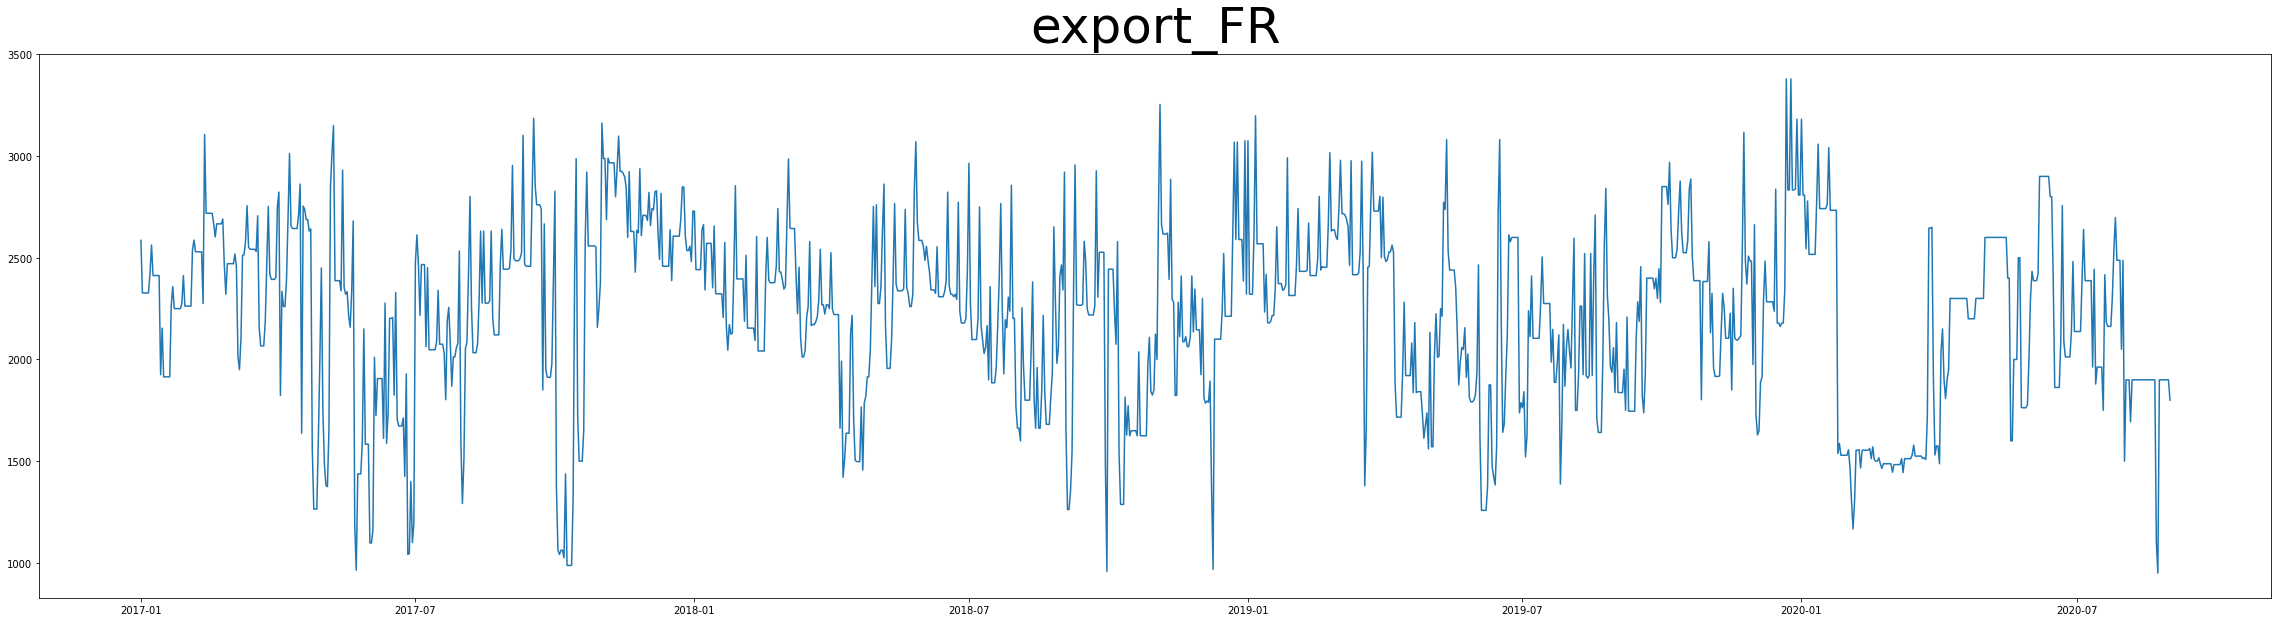

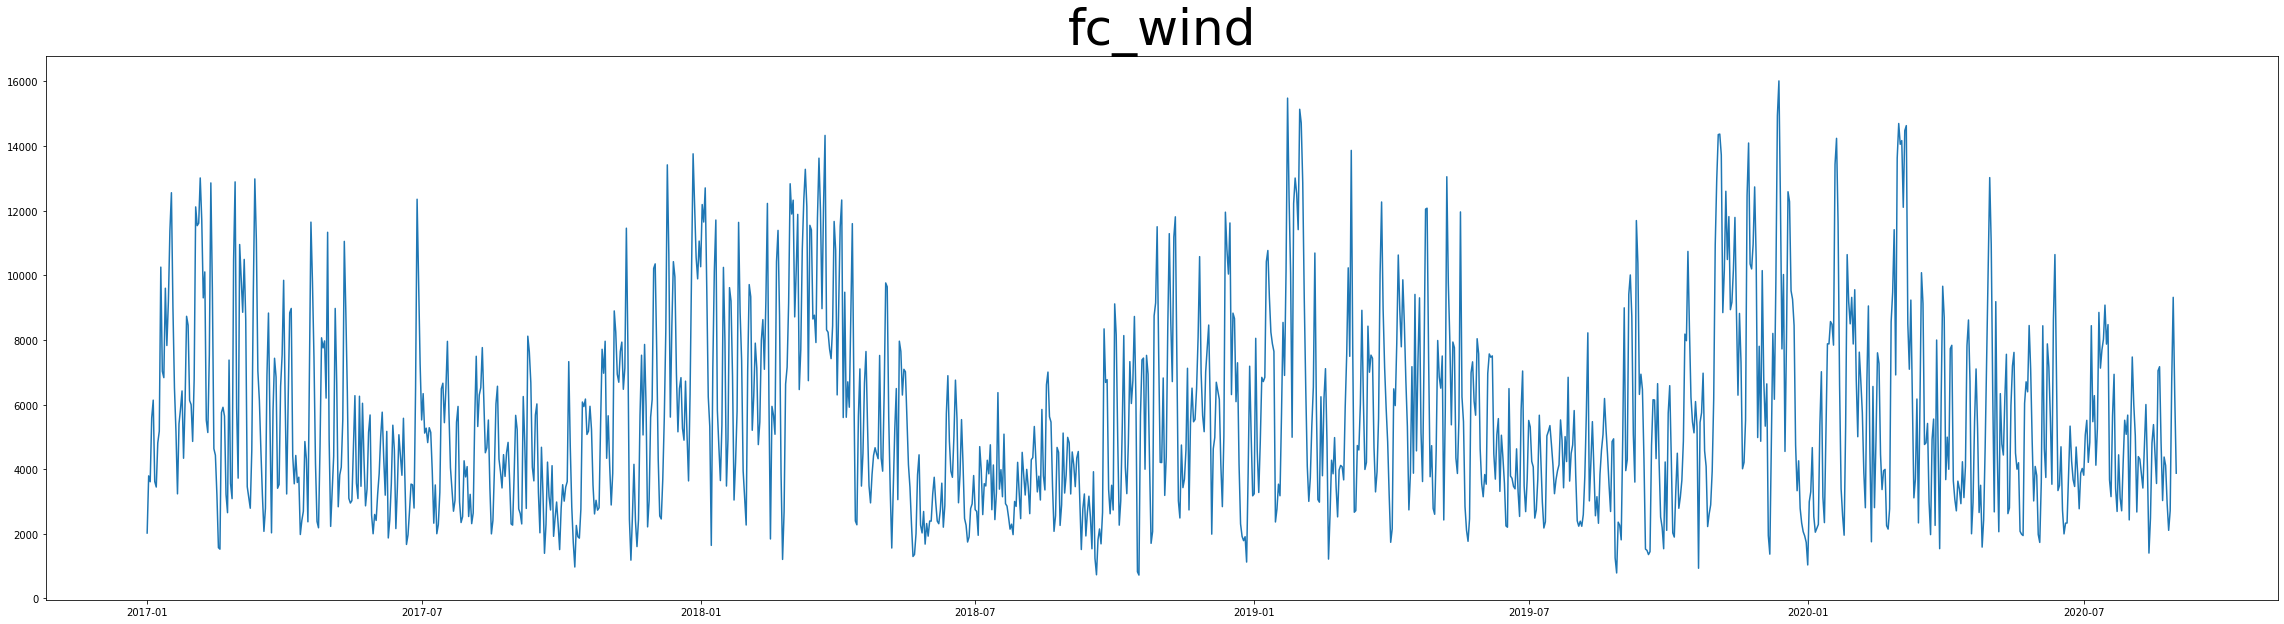

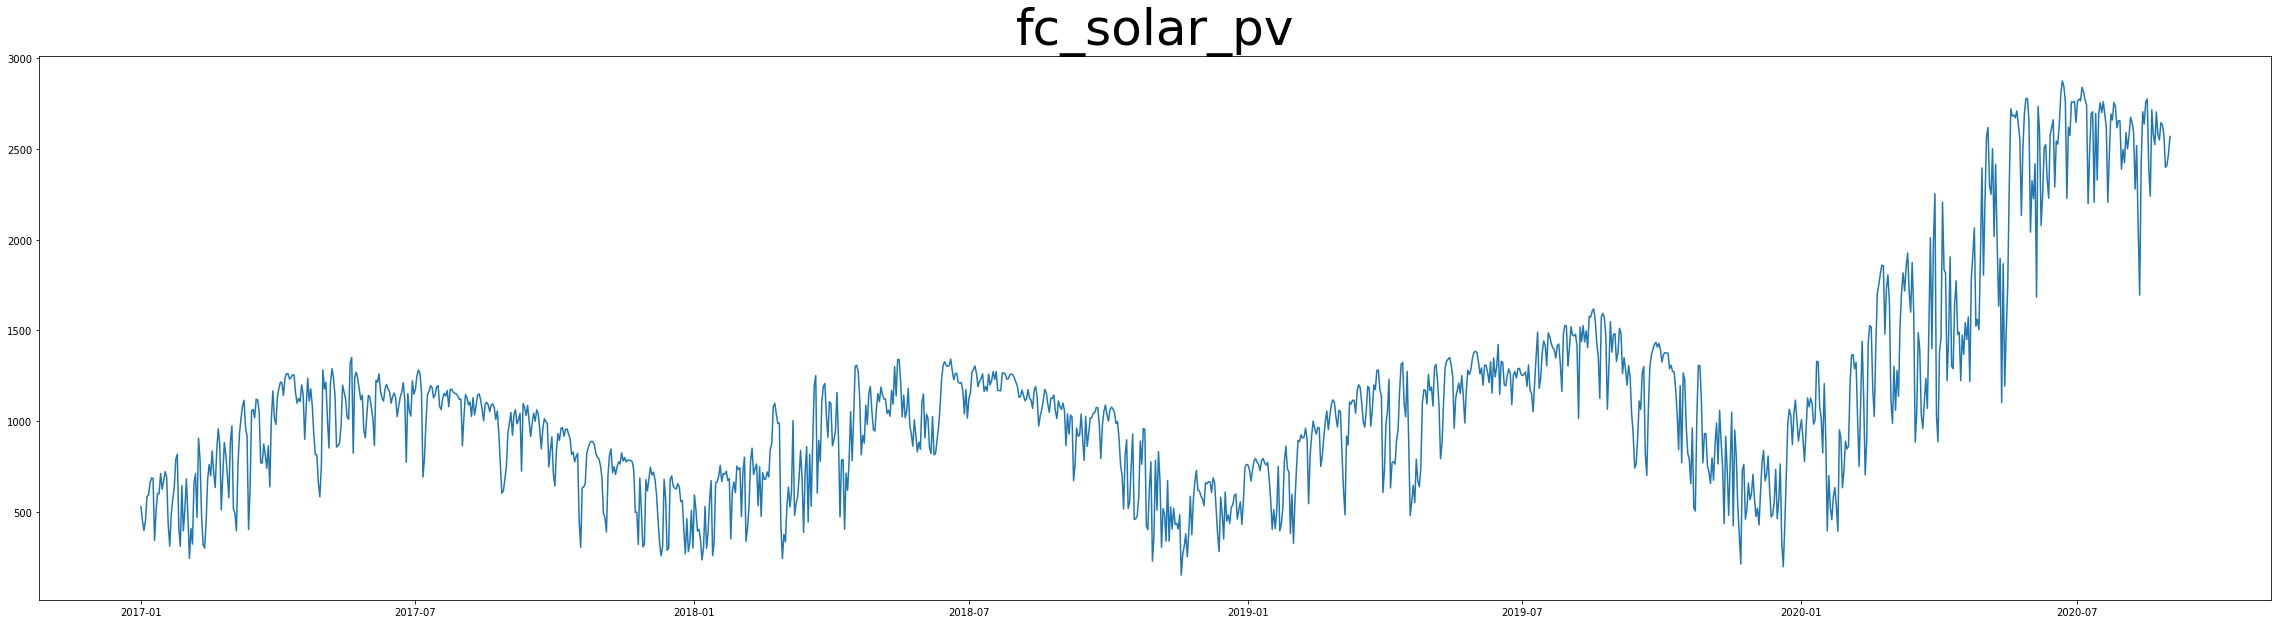

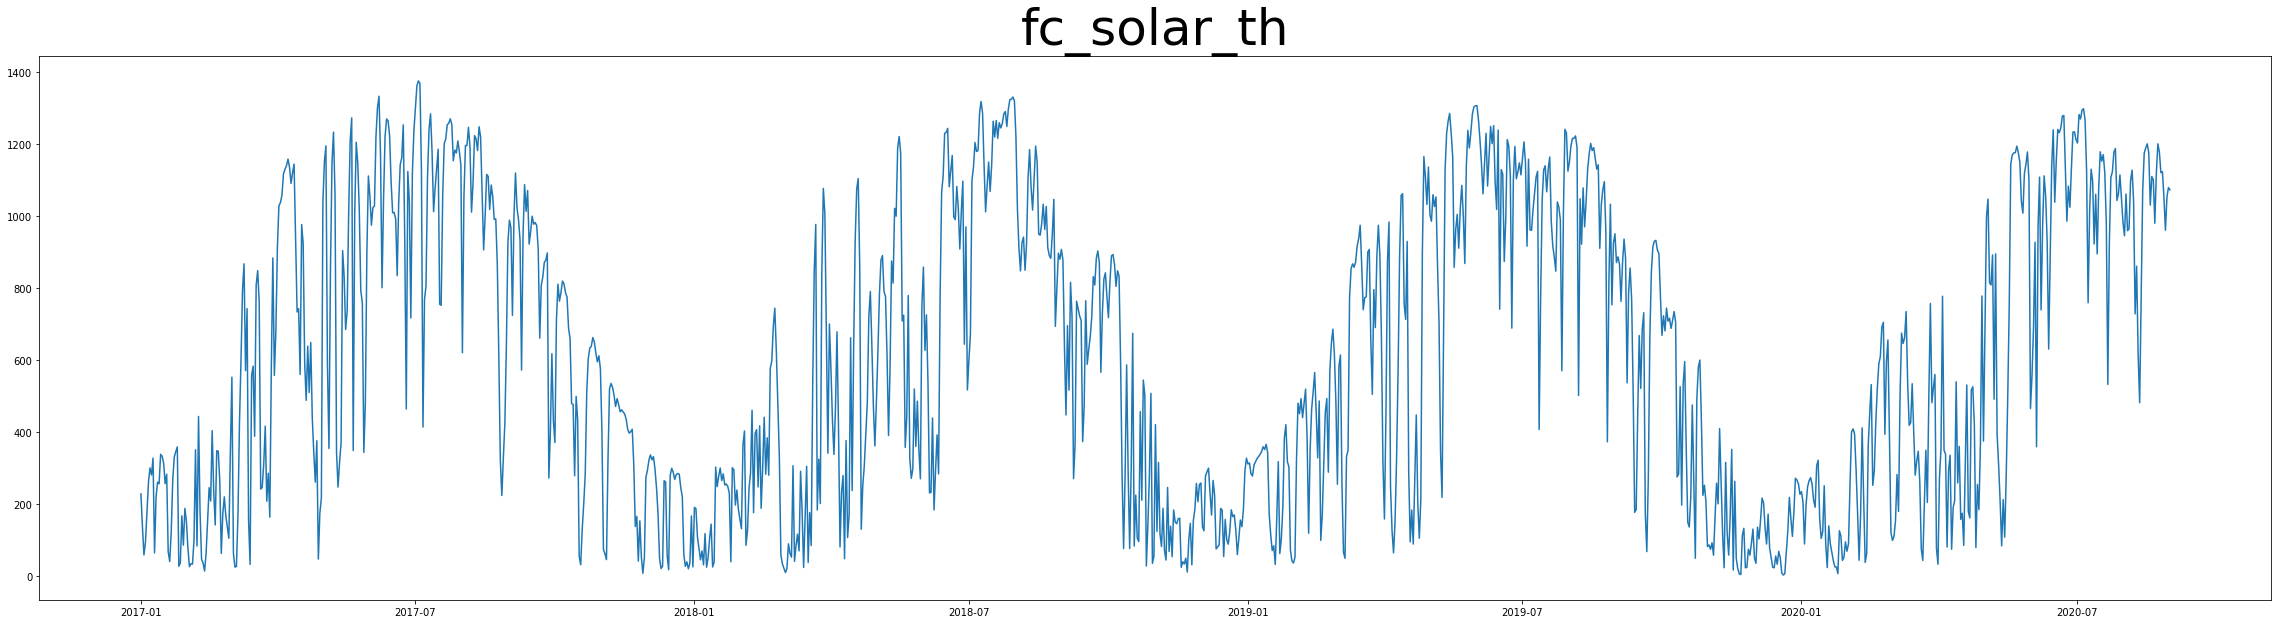

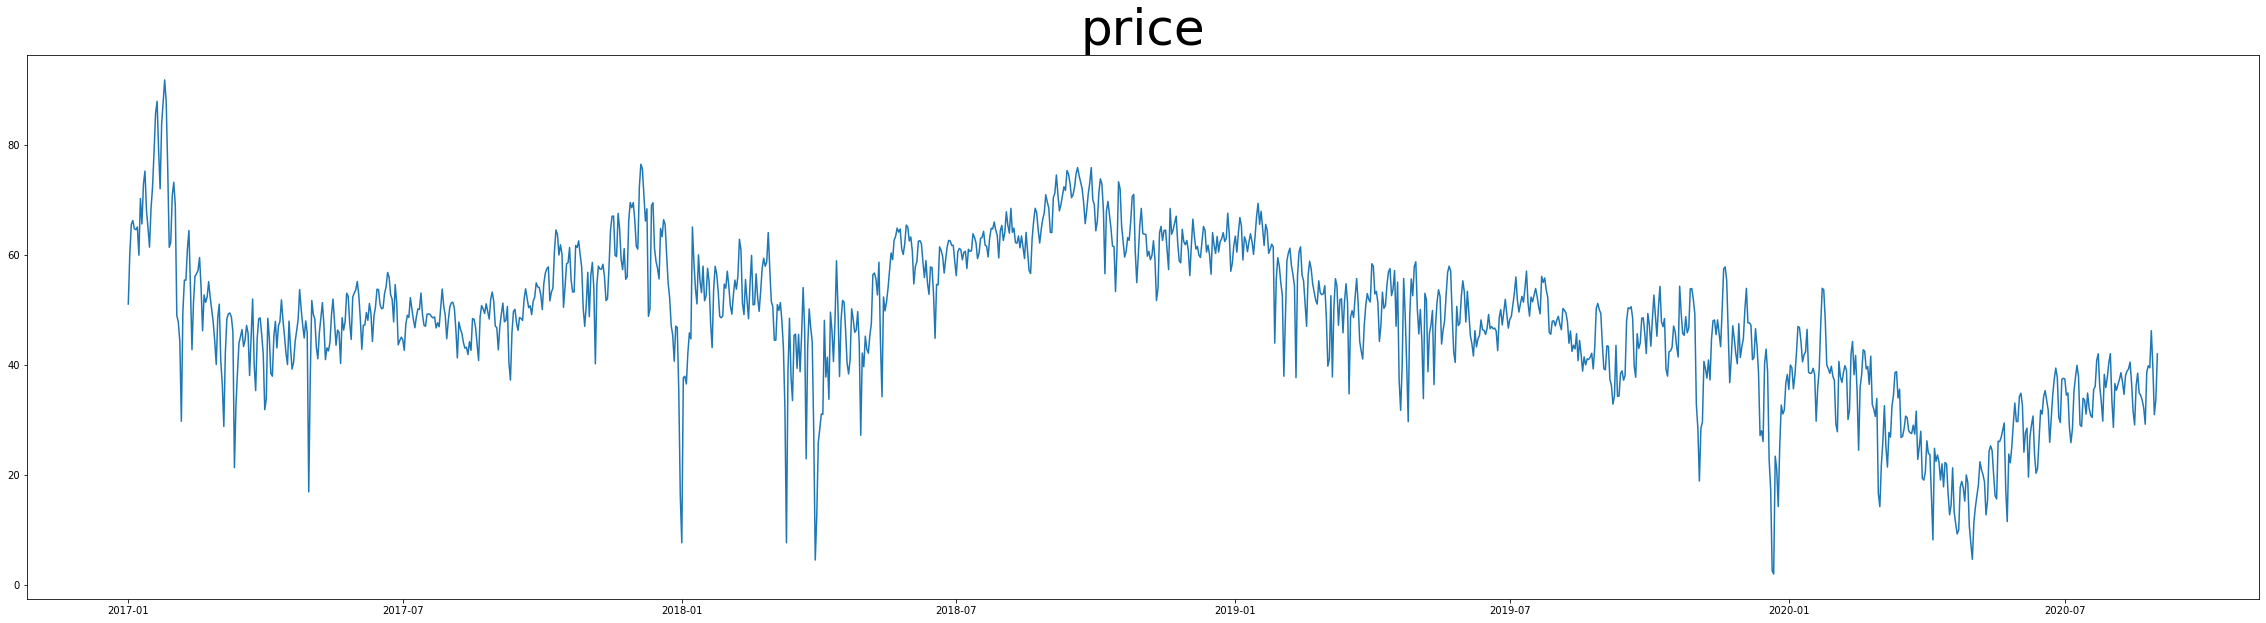

In [16]:
# line graphs of daily average for entire period

import matplotlib.pyplot as plt 

daily_avg_df=df_train.groupby(pd.Grouper(key='date')).mean()
for i in daily_avg_df.columns[:8]:
    plt.figure(figsize=(40,10))
    plt.plot(daily_avg_df[i])
    plt.title(i, fontsize=50)
    plt.show()

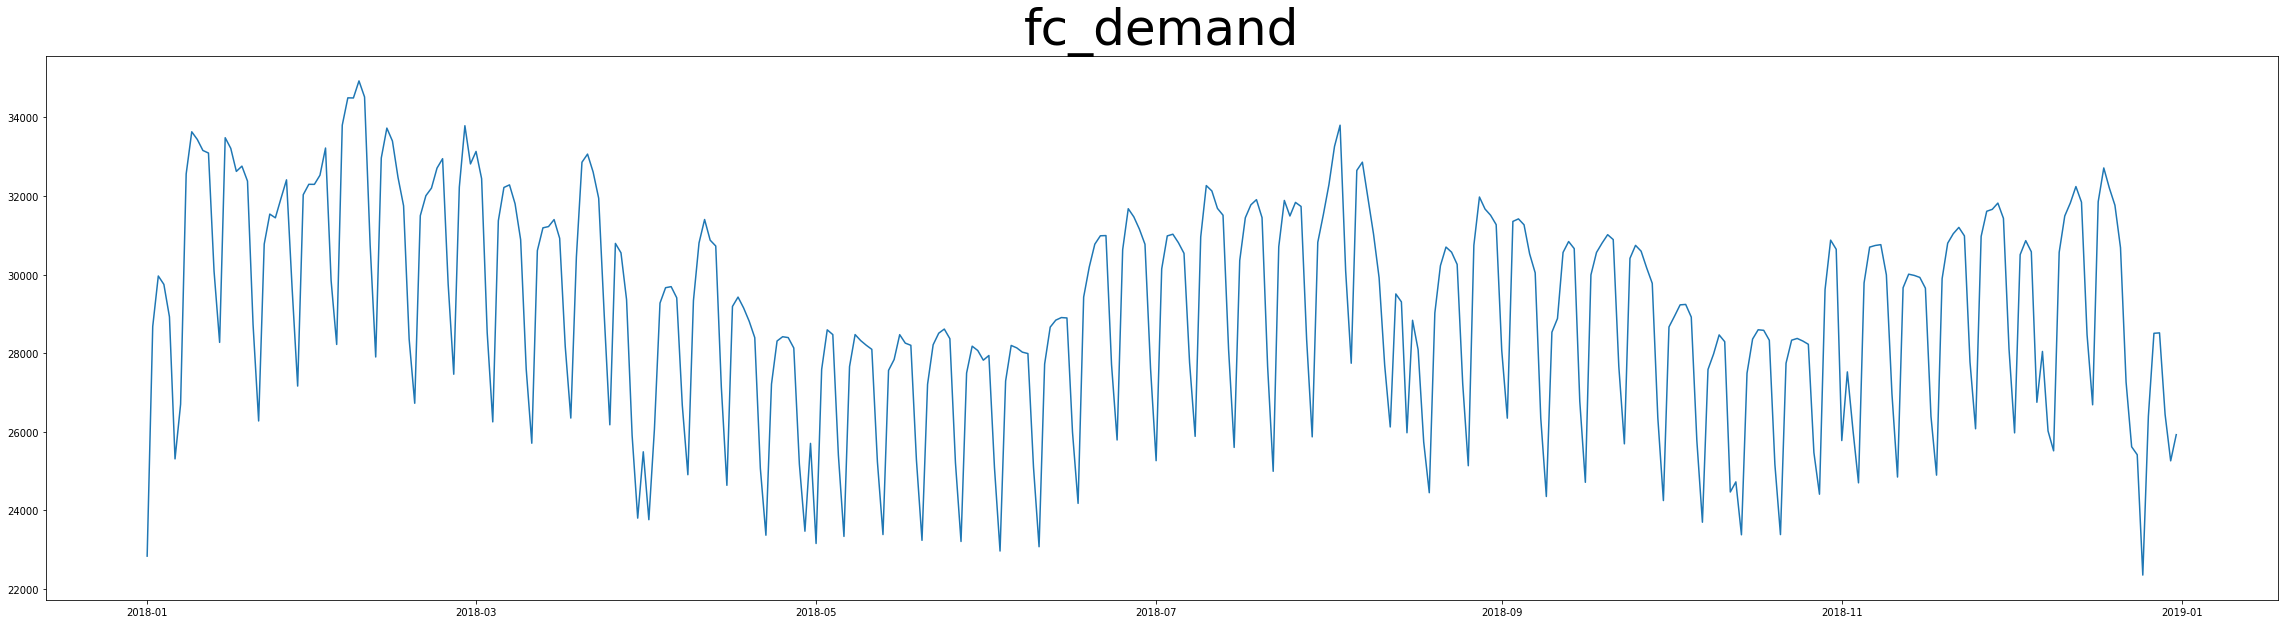

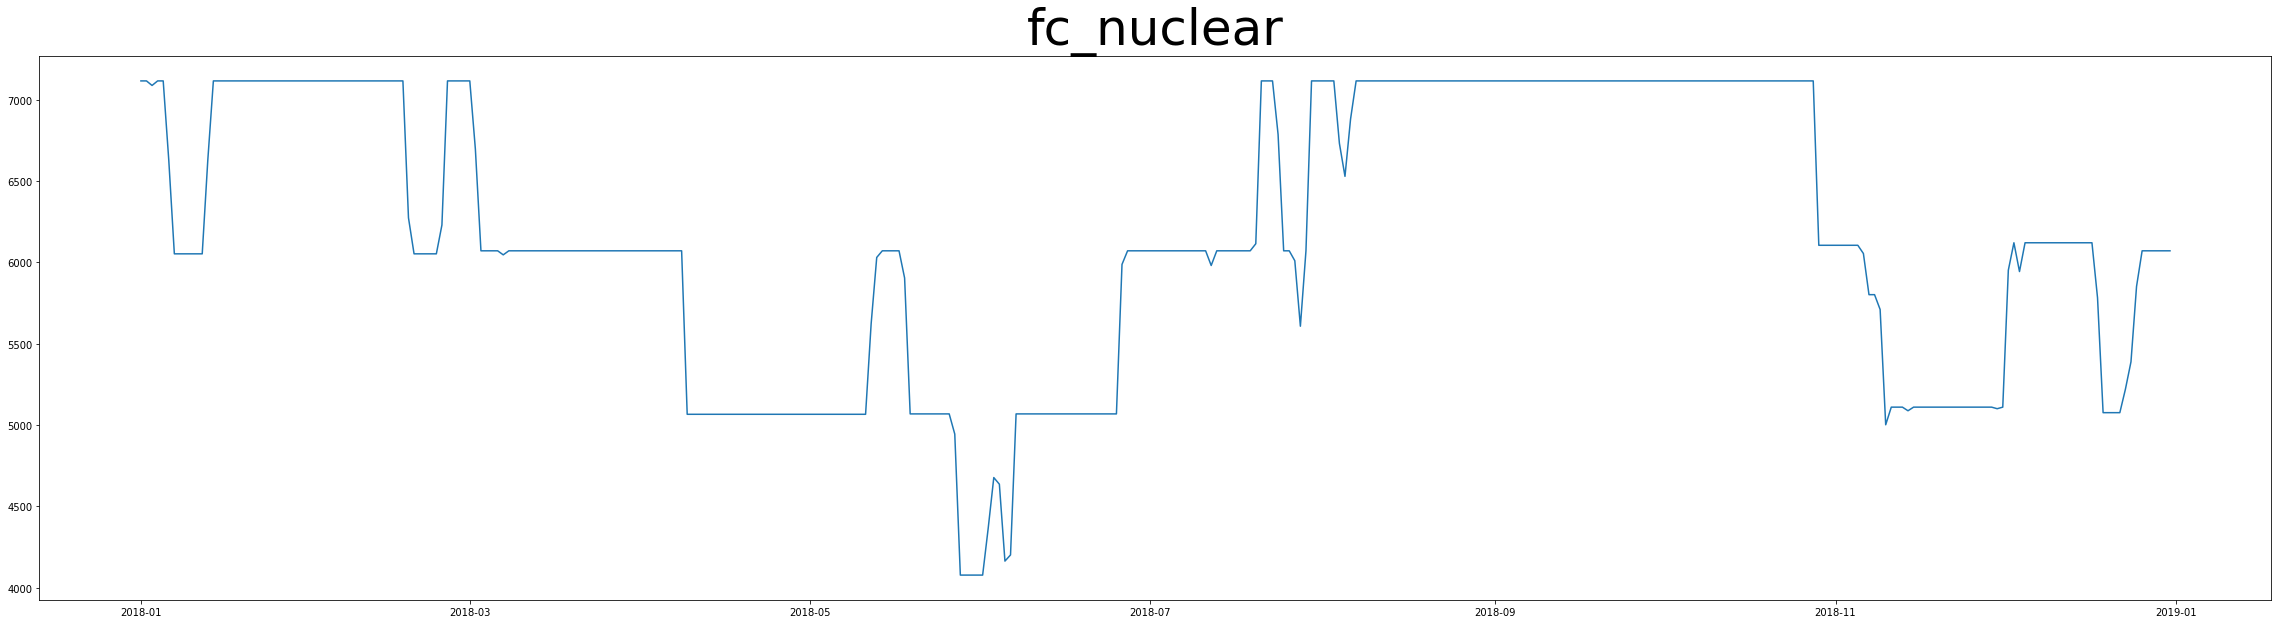

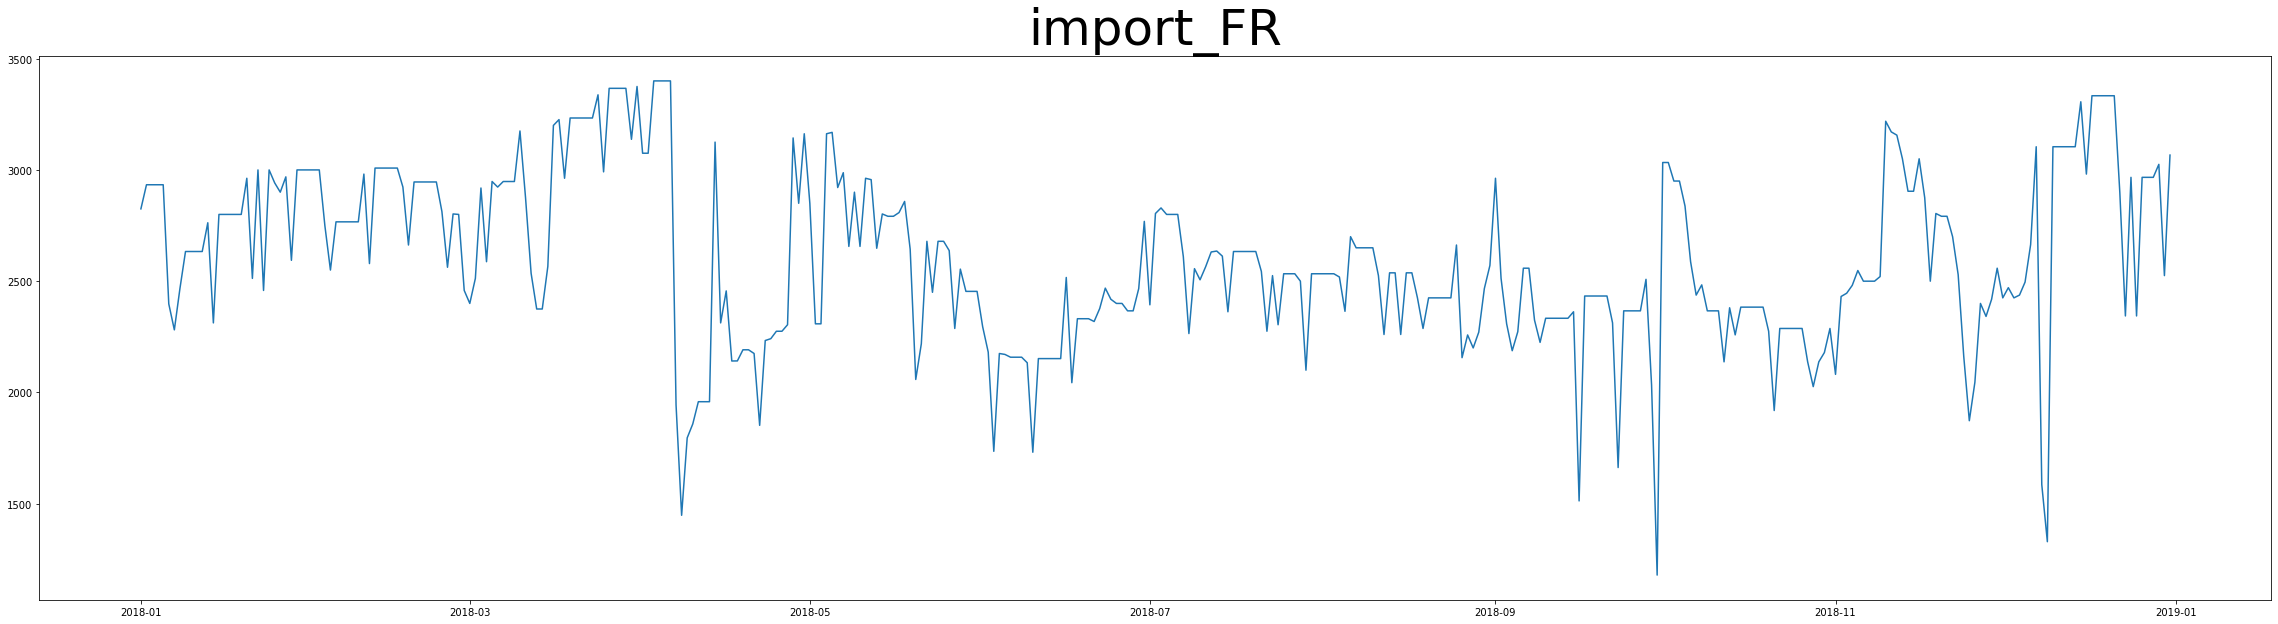

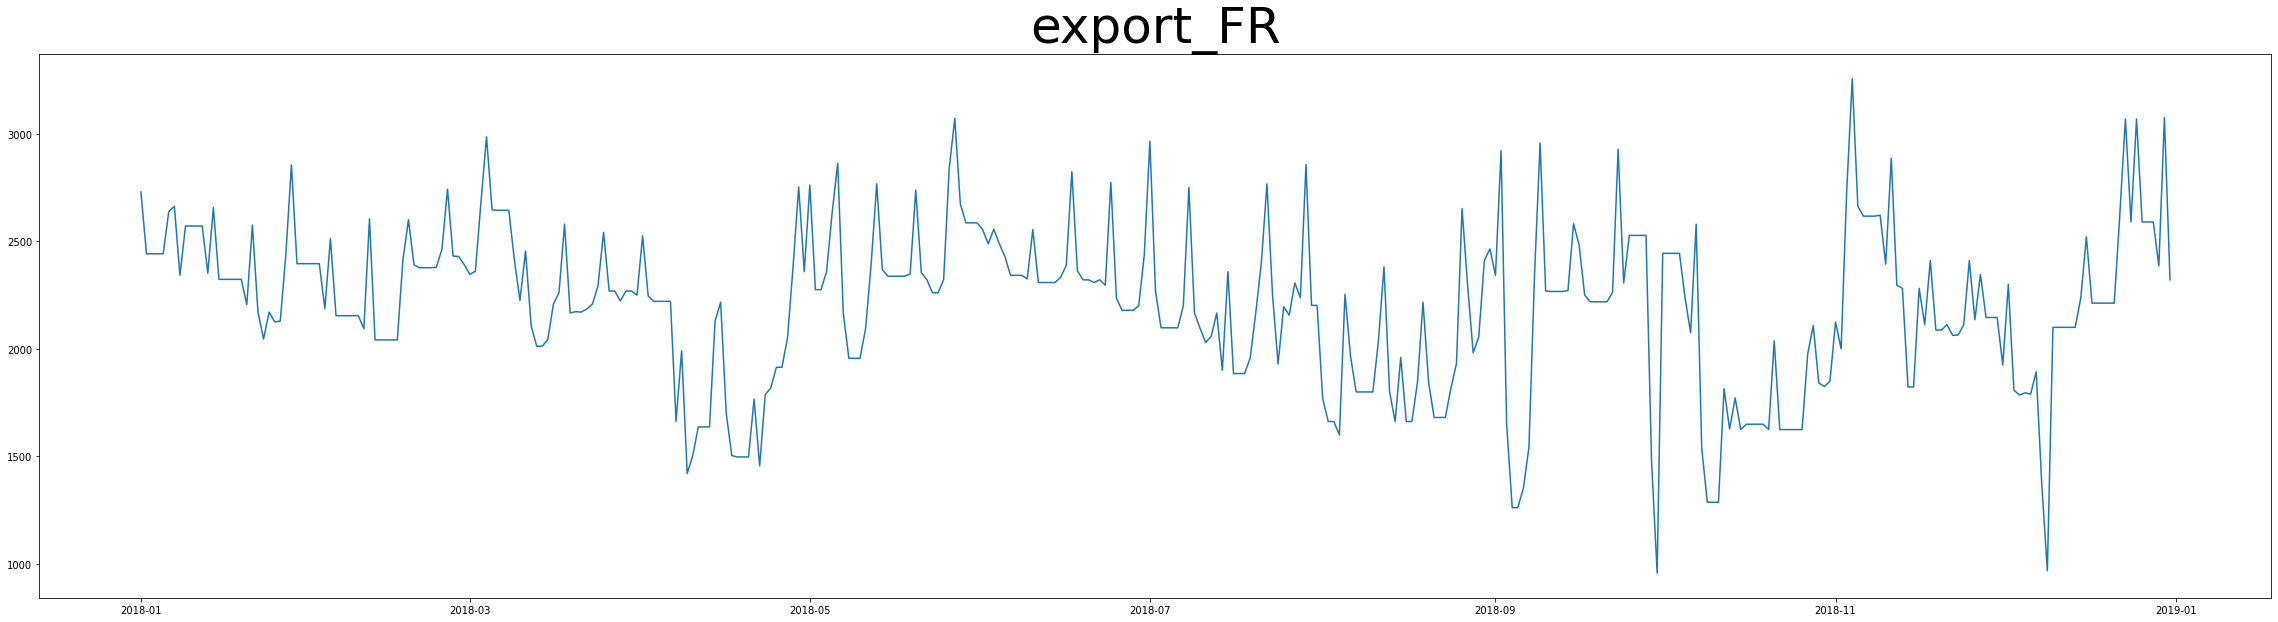

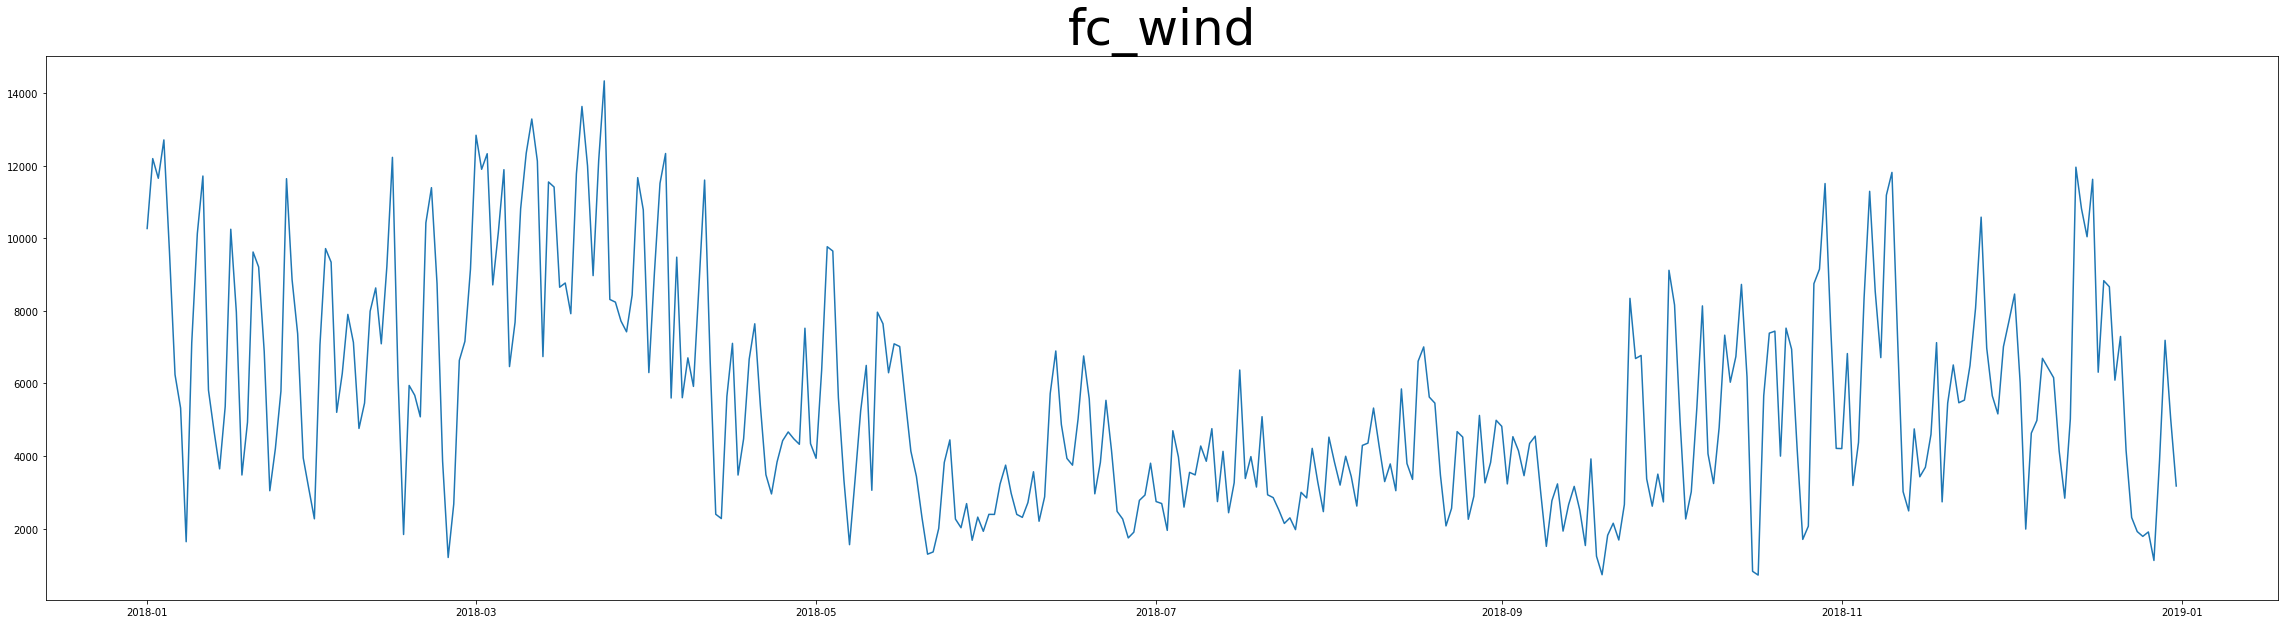

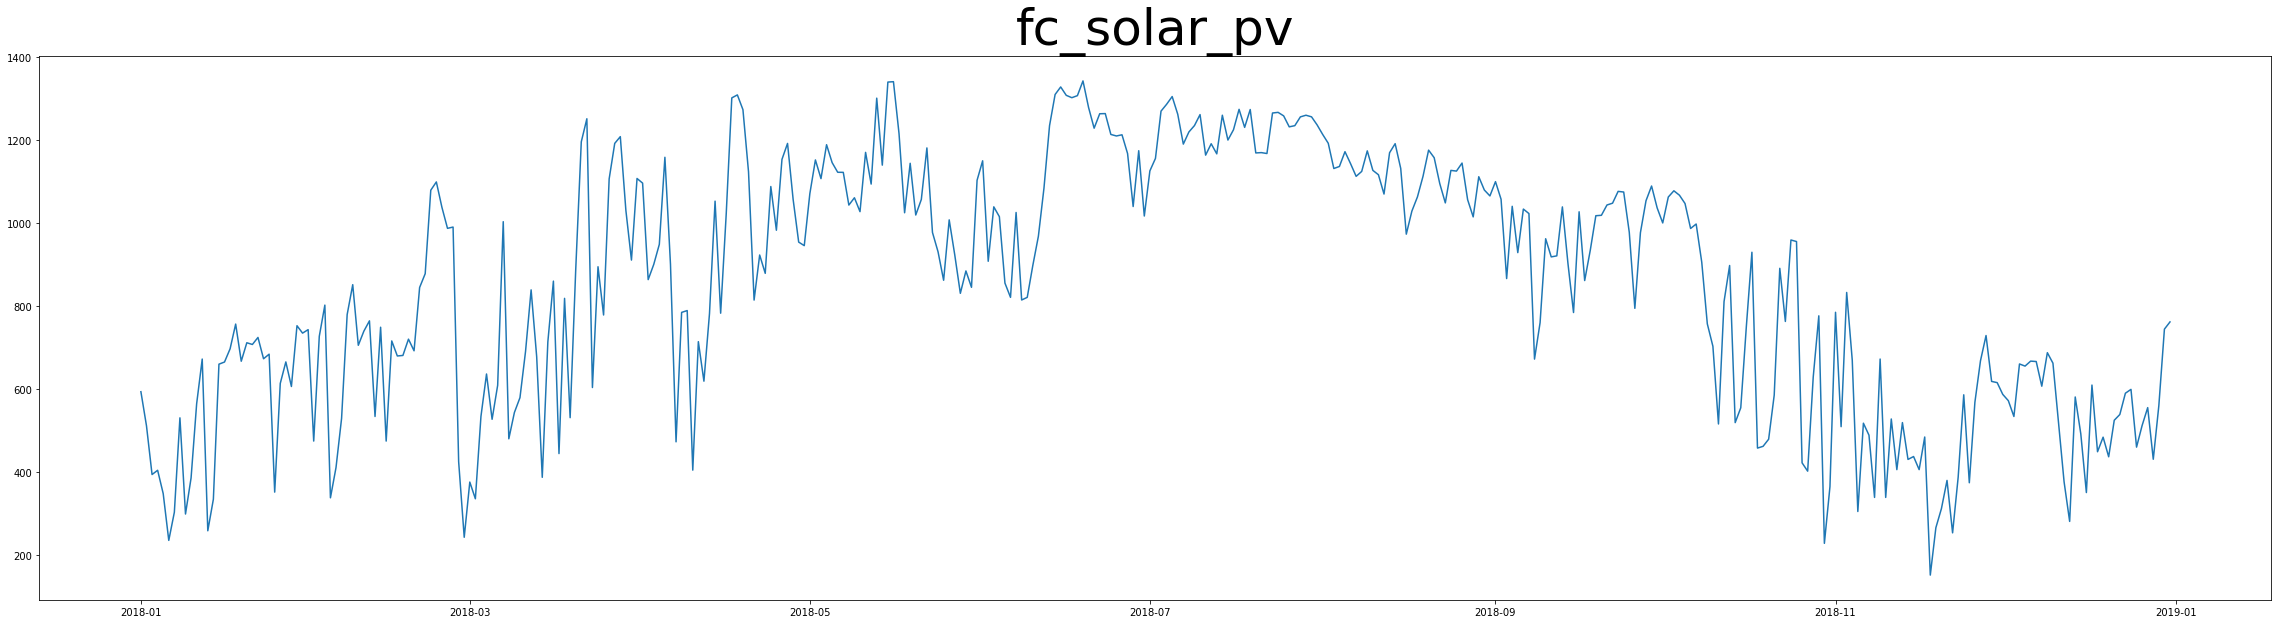

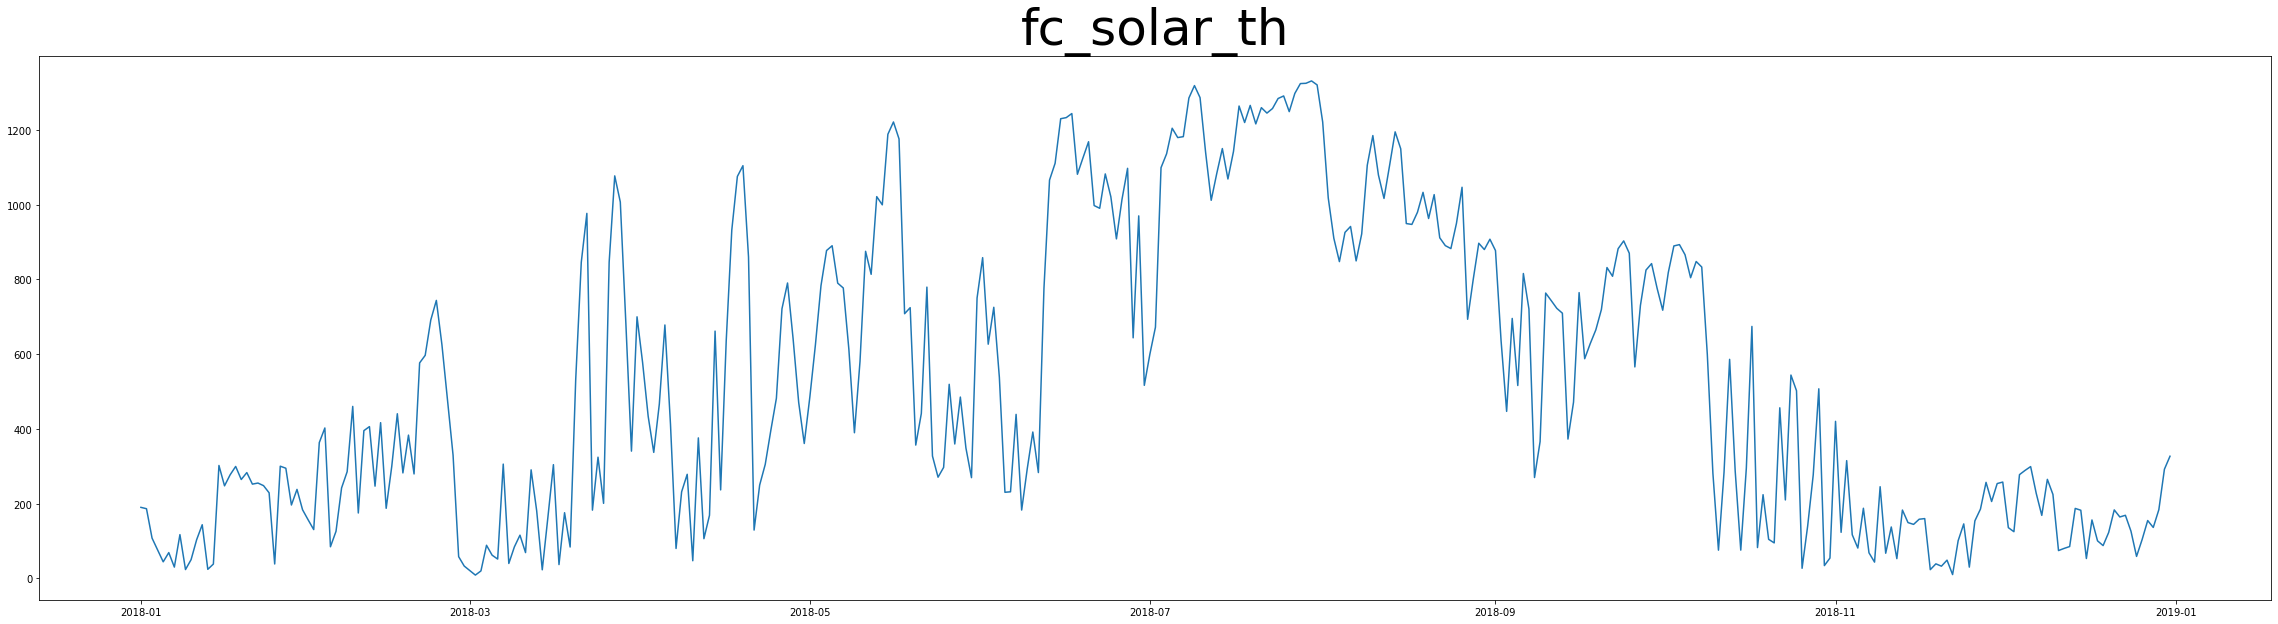

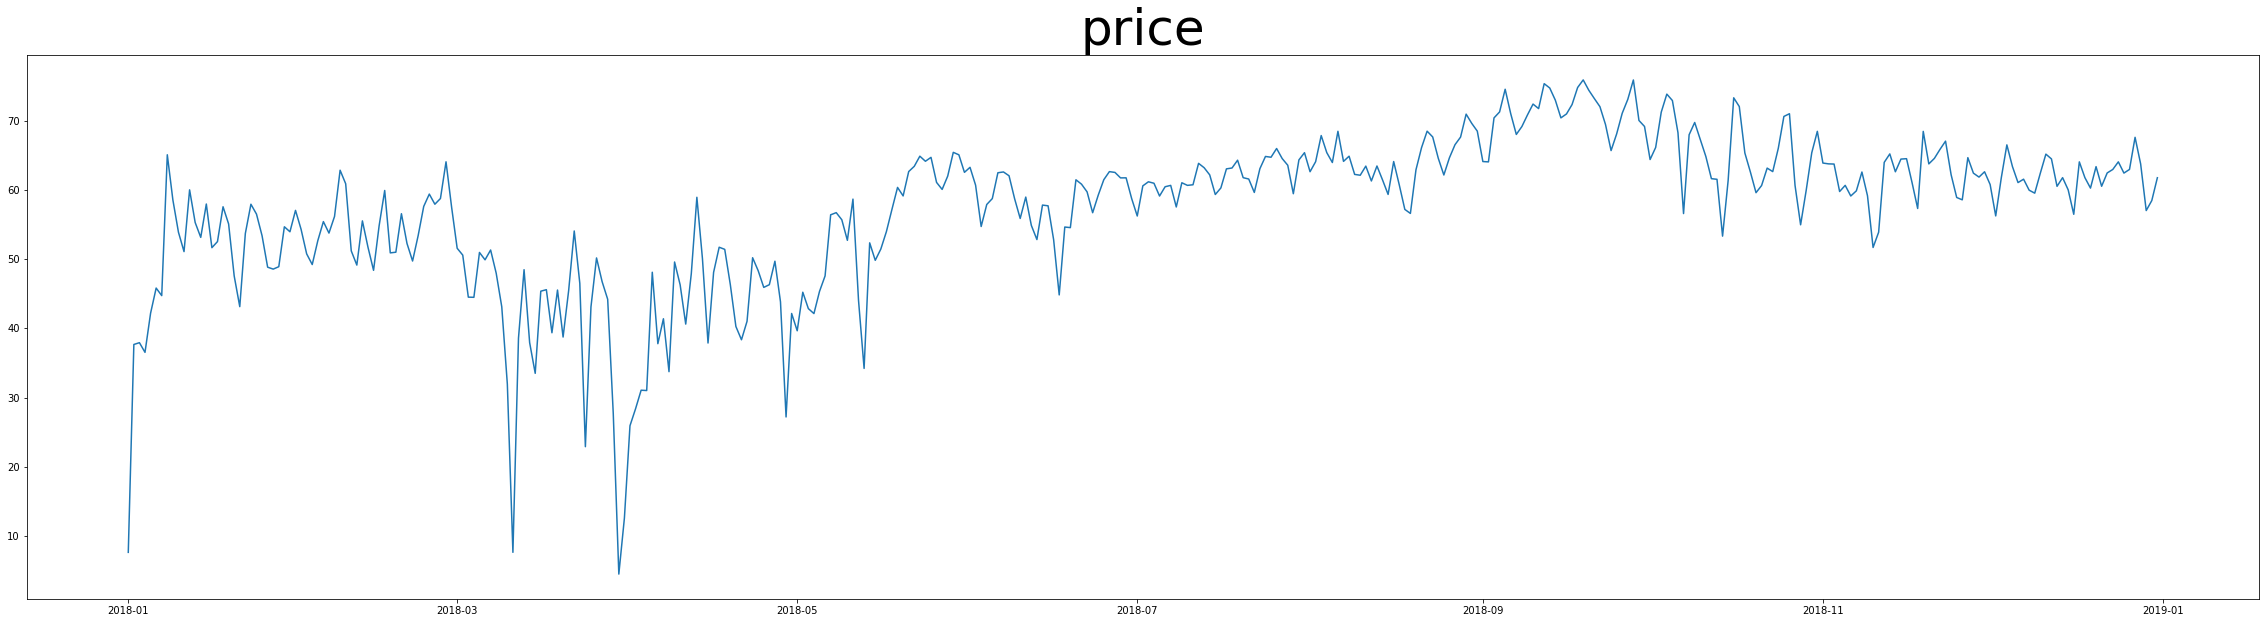

In [17]:
# zoom on a specific year (2018)

one_year_daily_avg_df=df_train[pd.DatetimeIndex(df_train['date']).year == 2018].groupby(pd.Grouper(key='date')).mean()

for i in one_year_daily_avg_df.columns[:8]:
    plt.figure(figsize=(40,10))
    plt.plot(one_year_daily_avg_df[i])
    plt.title(i, fontsize=50)
    plt.show()

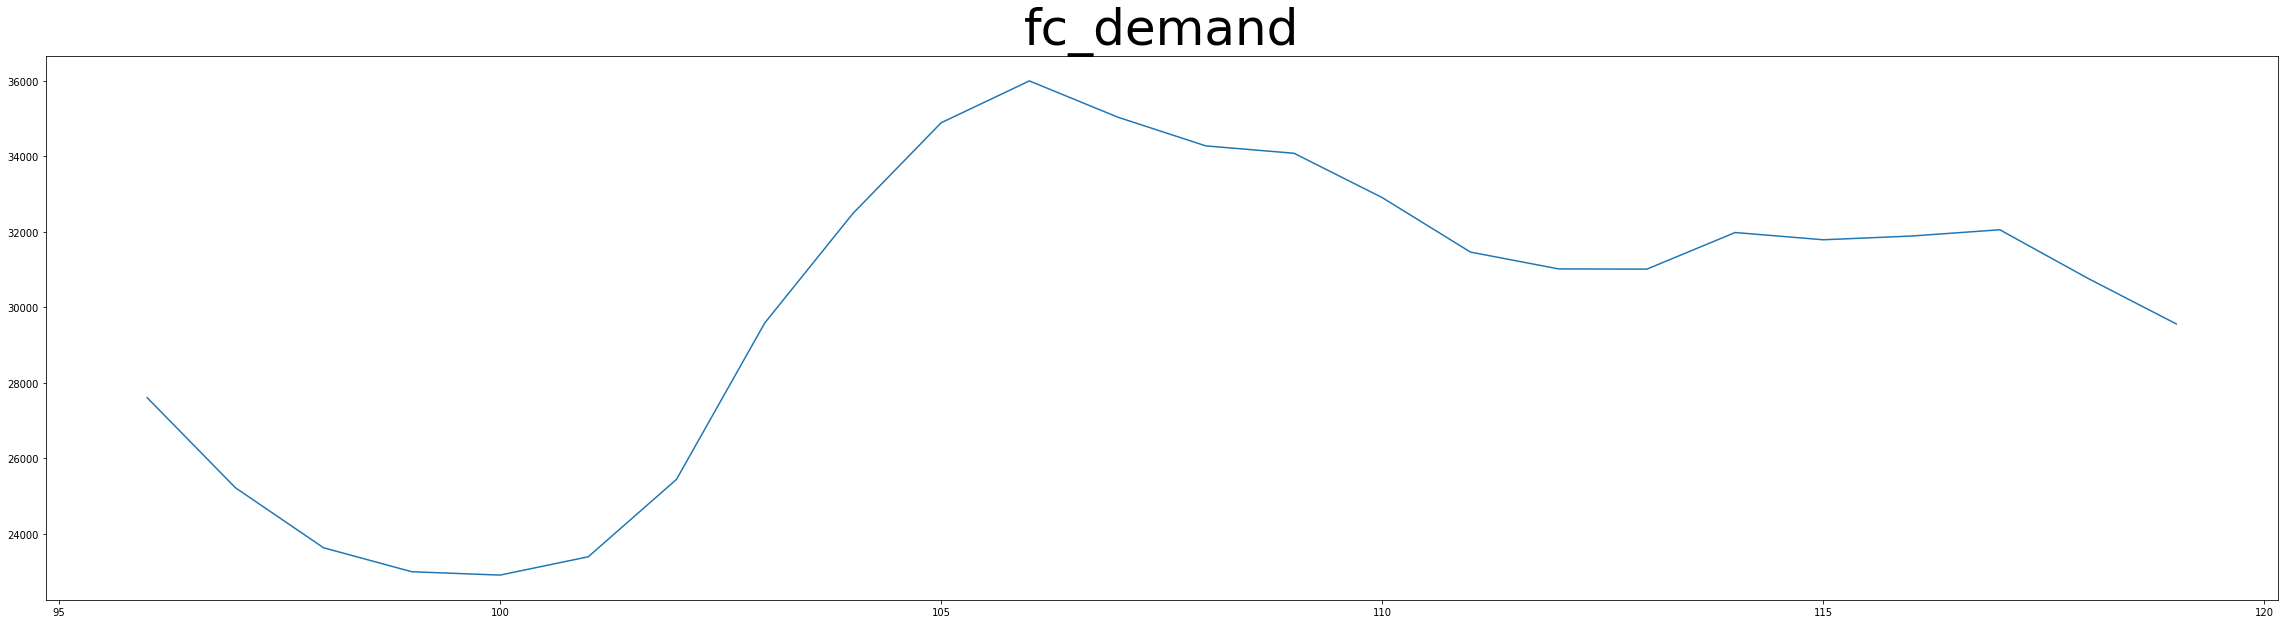

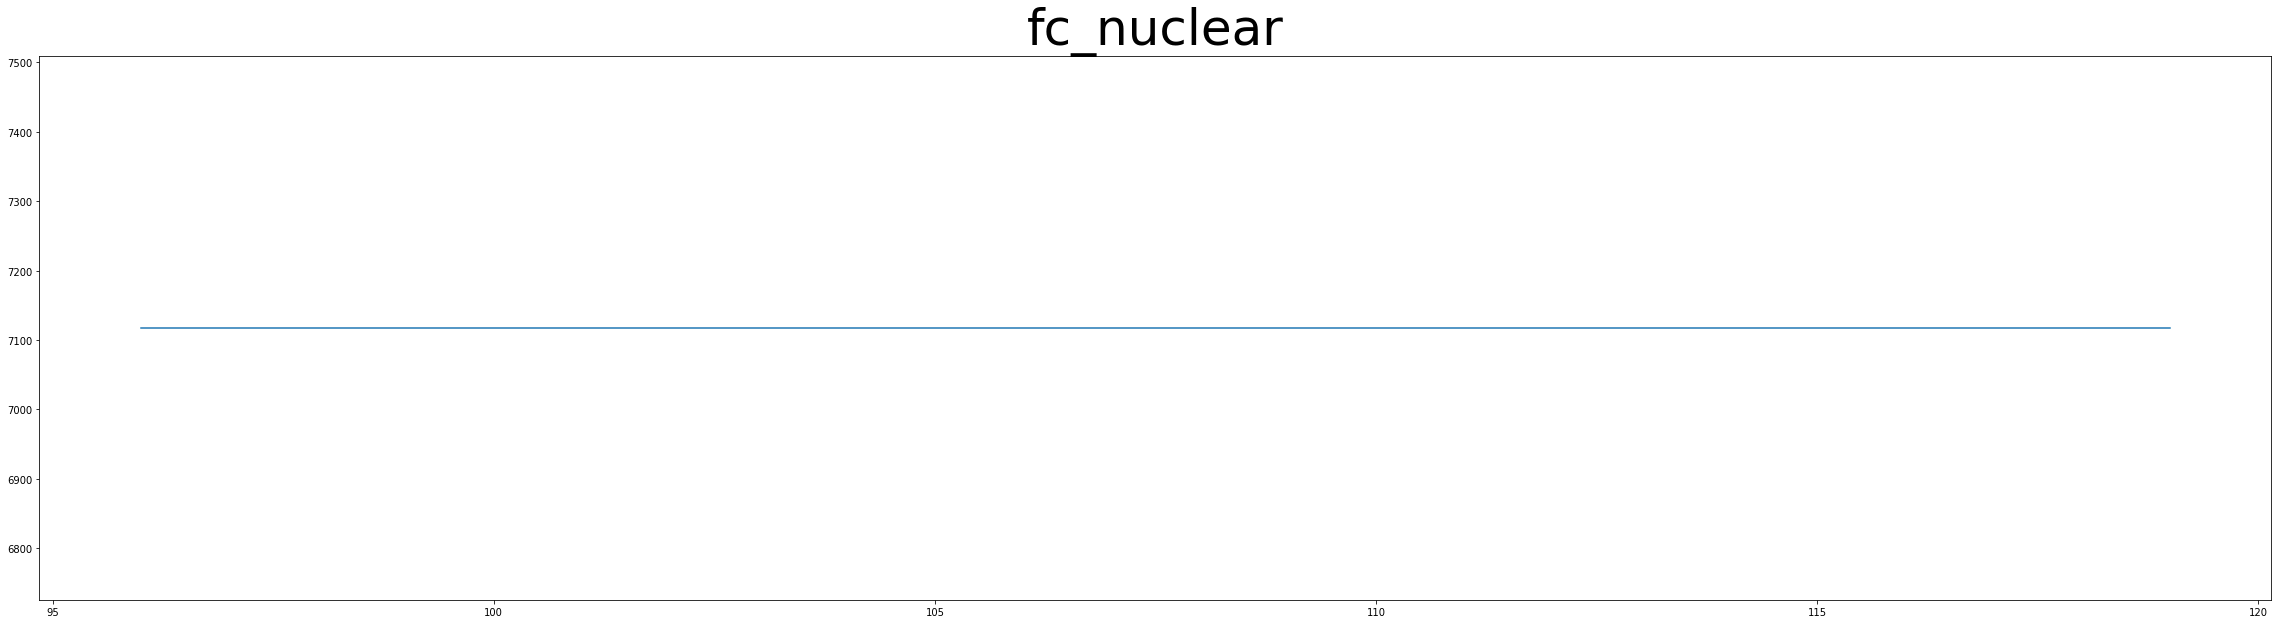

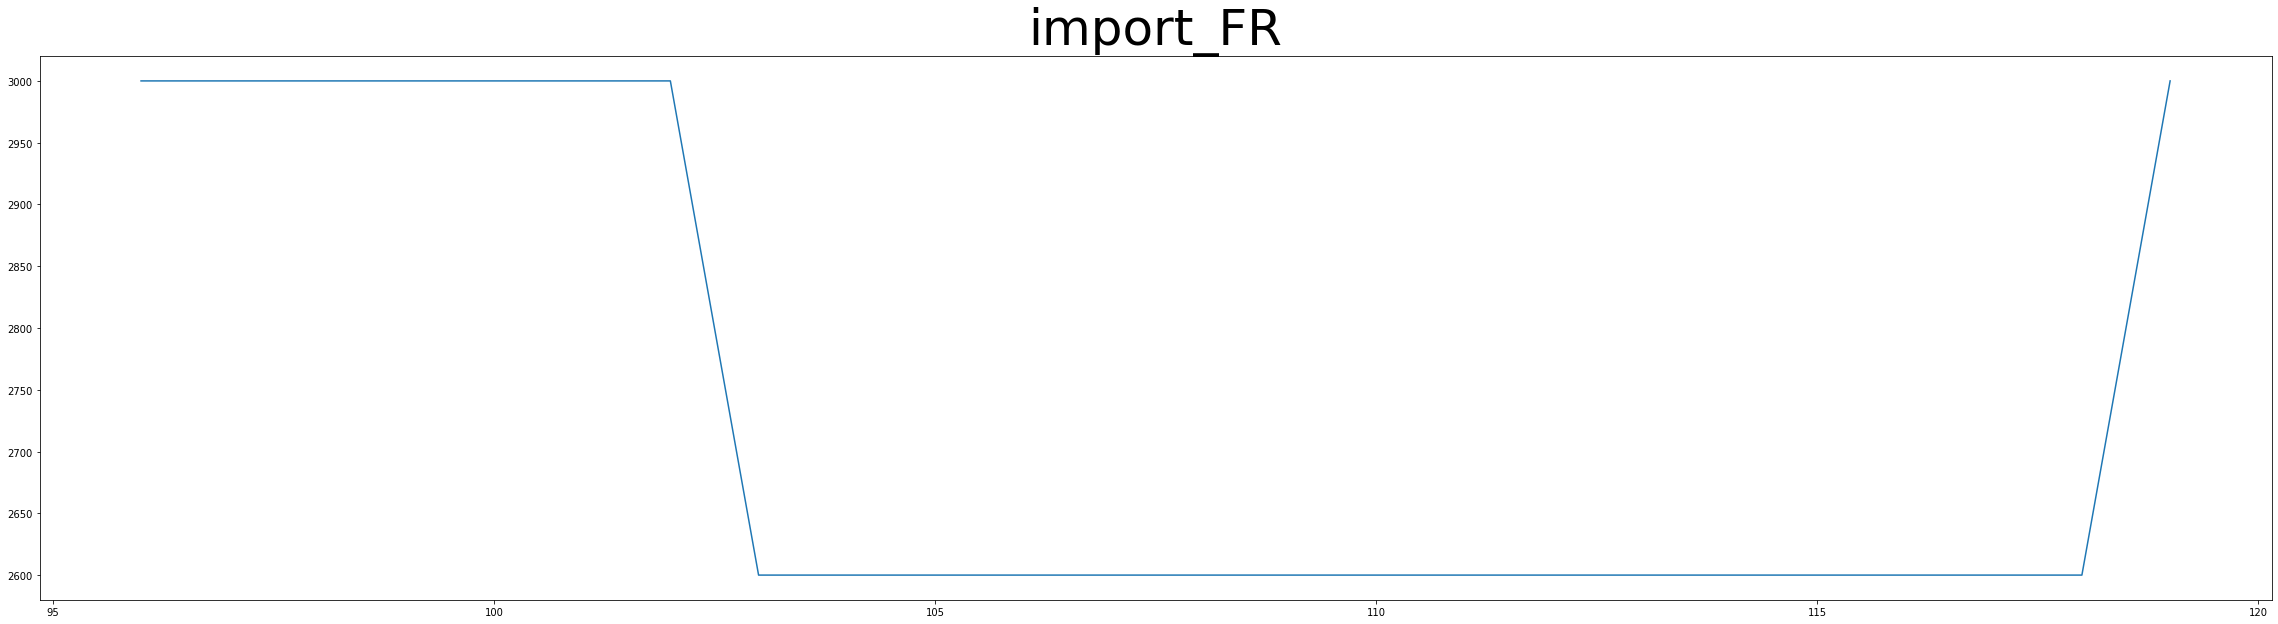

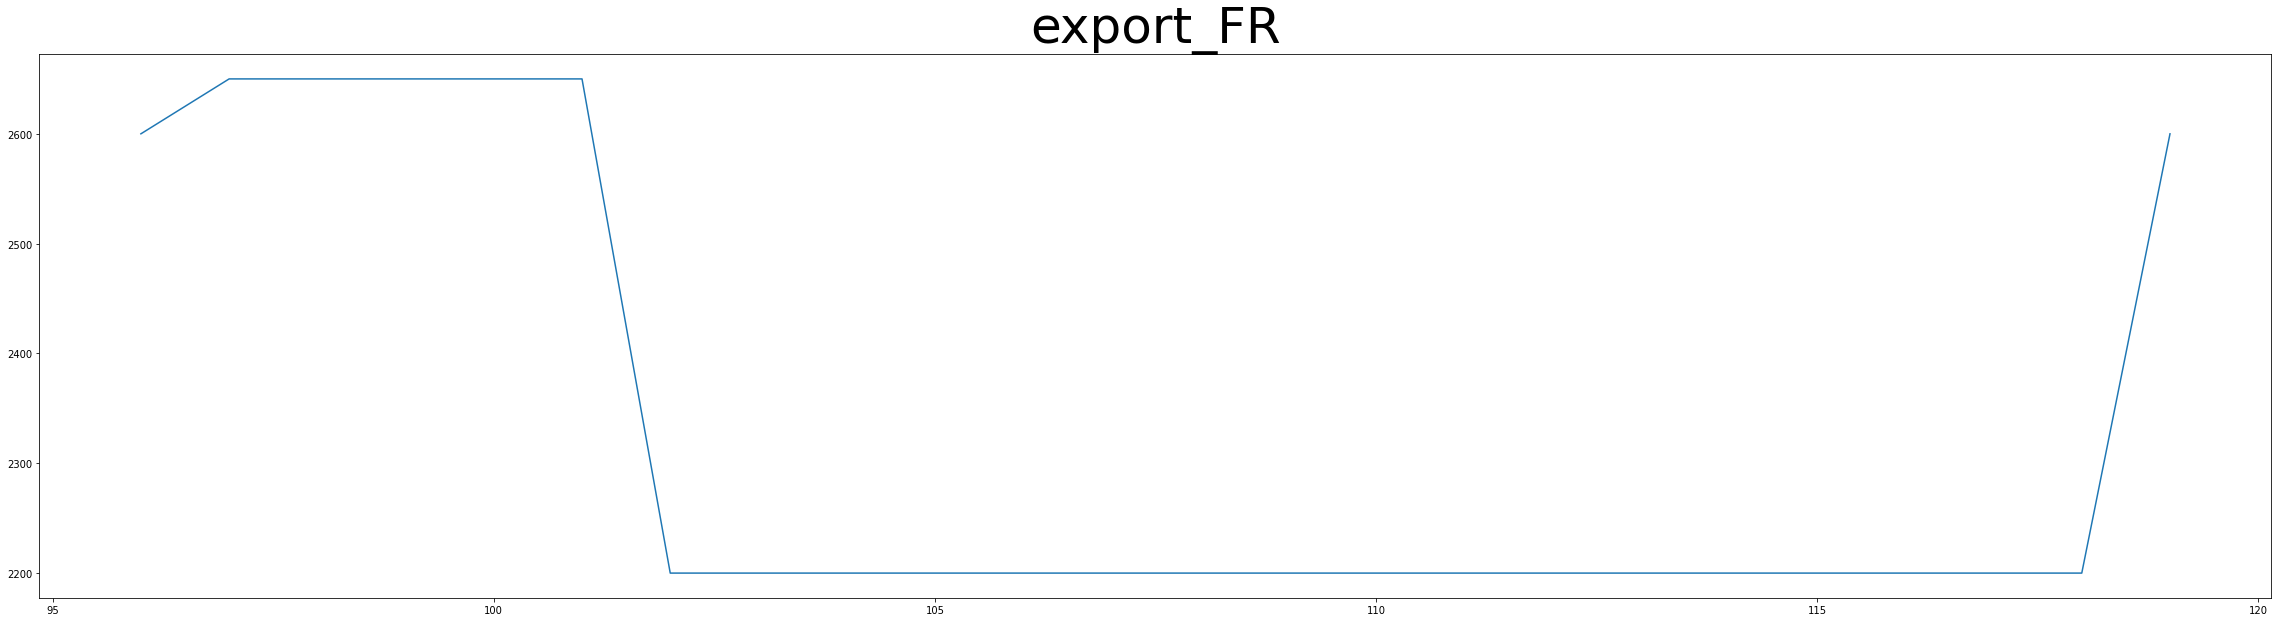

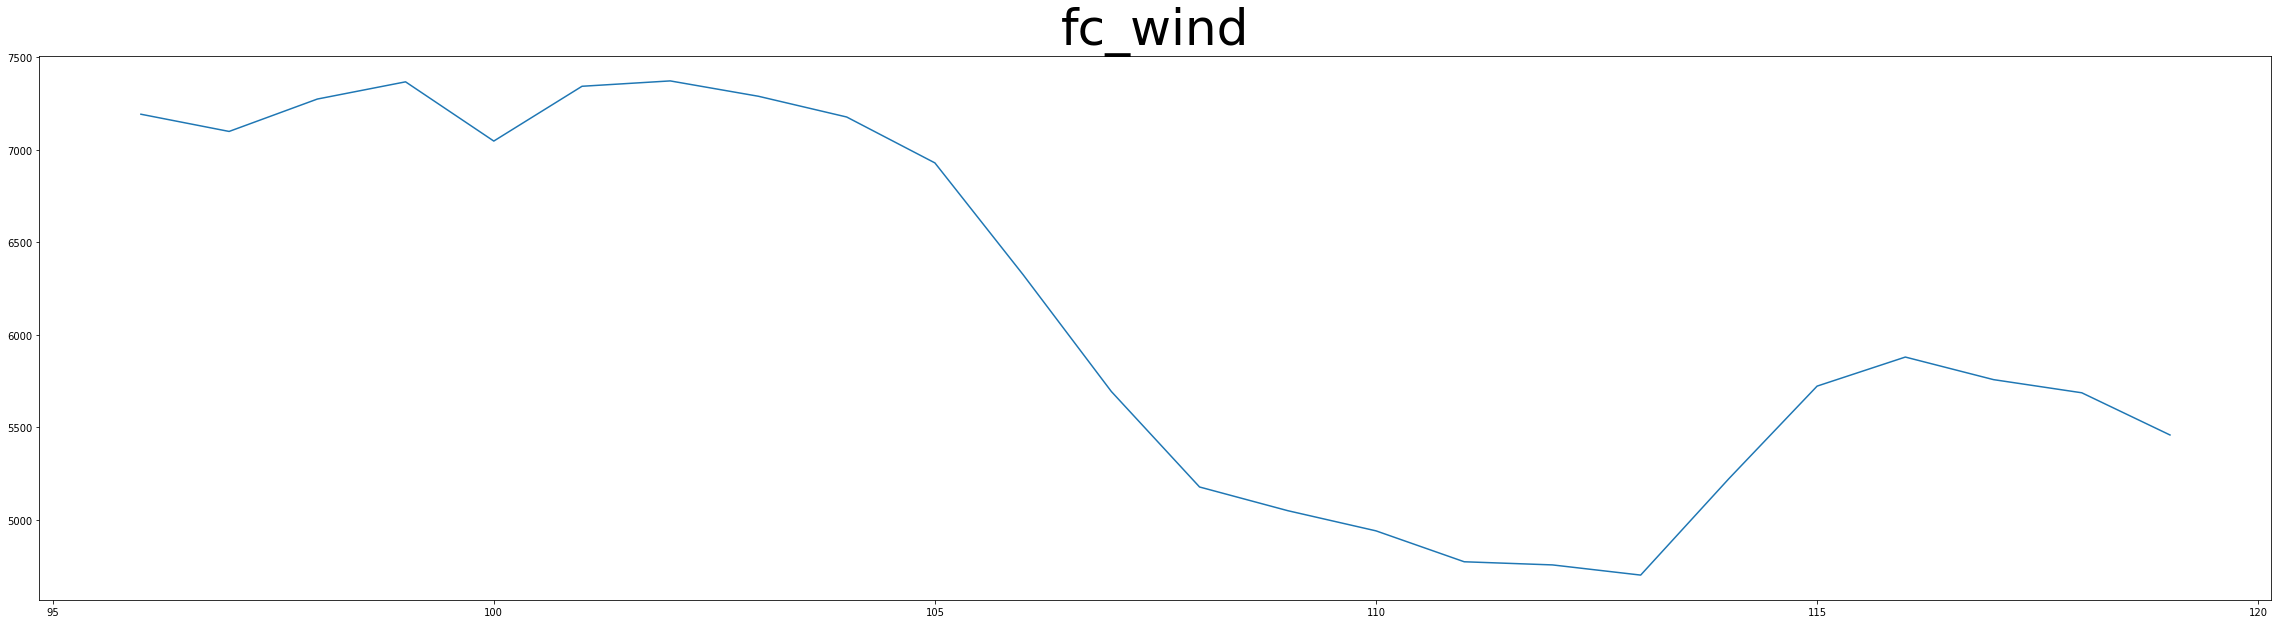

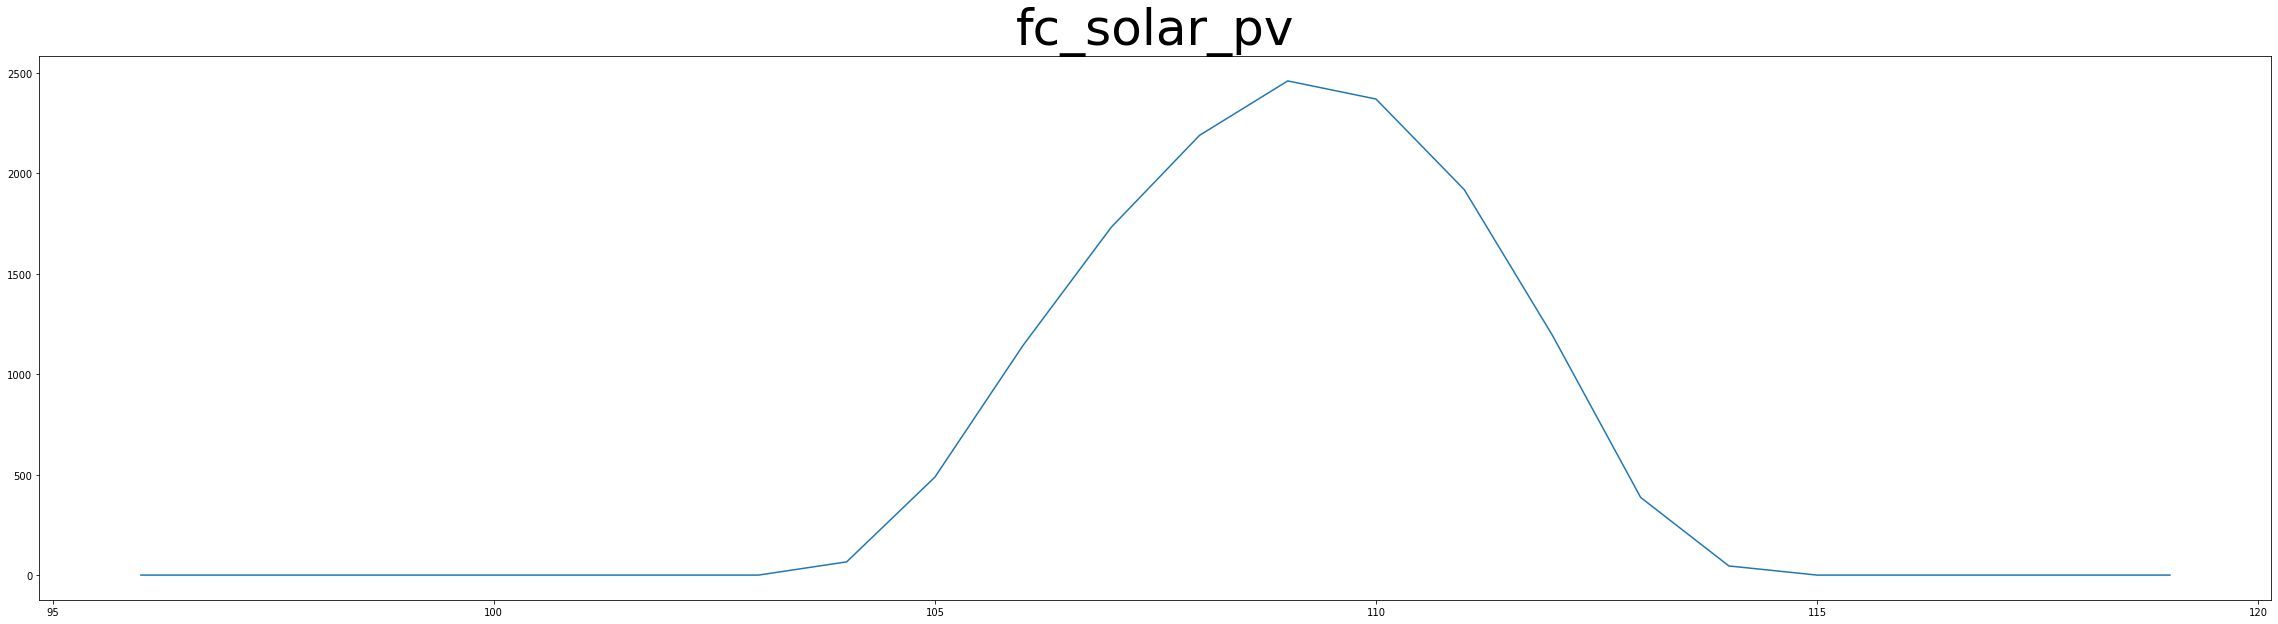

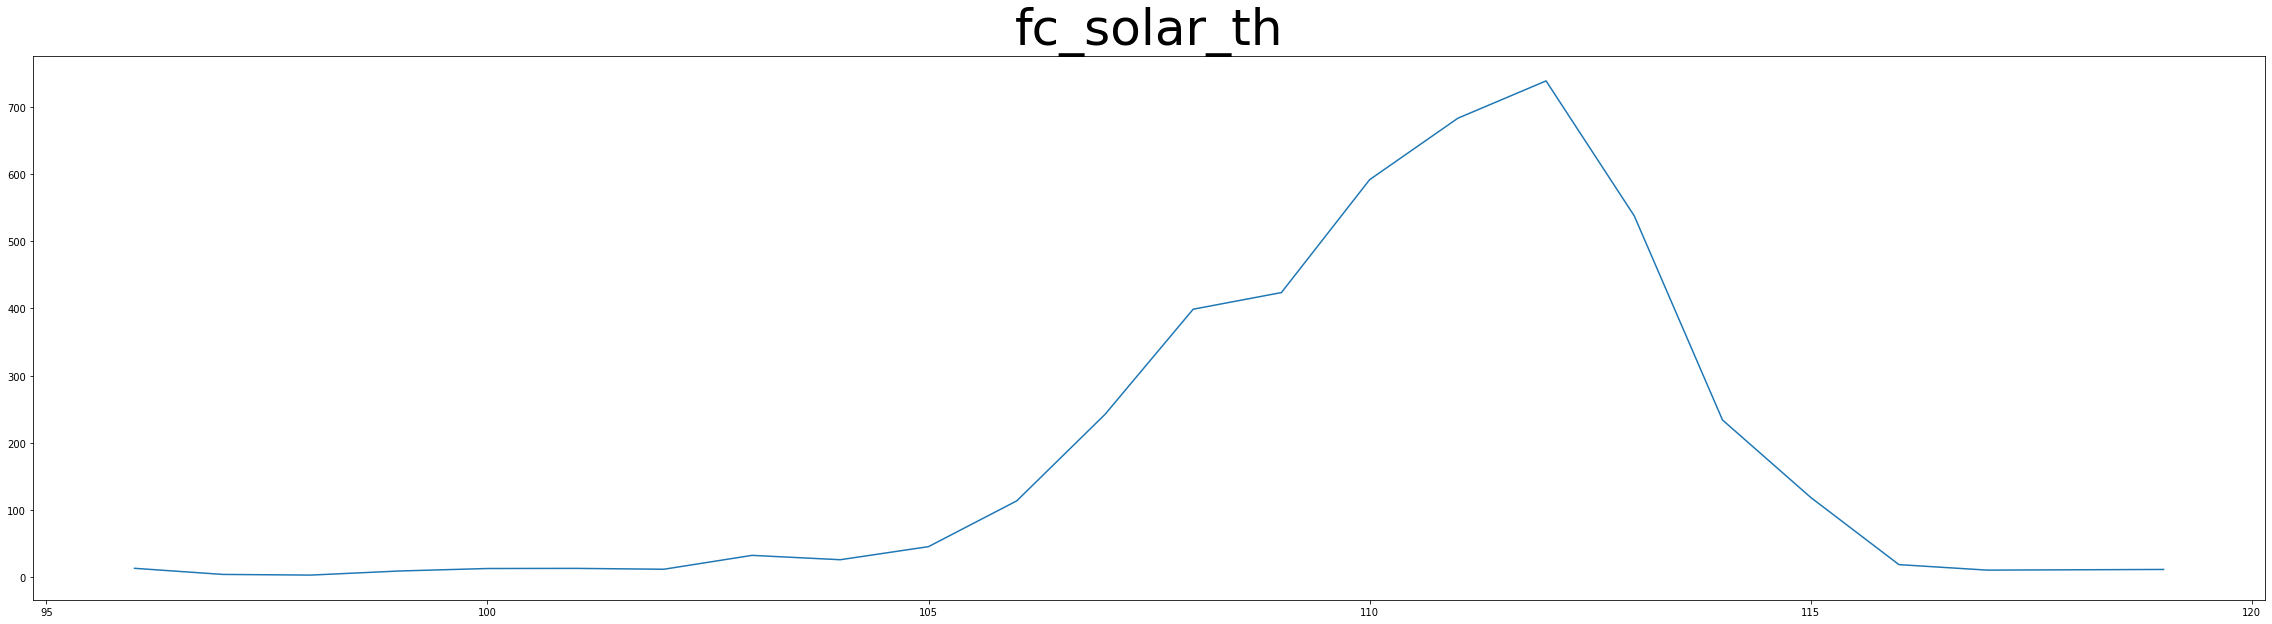

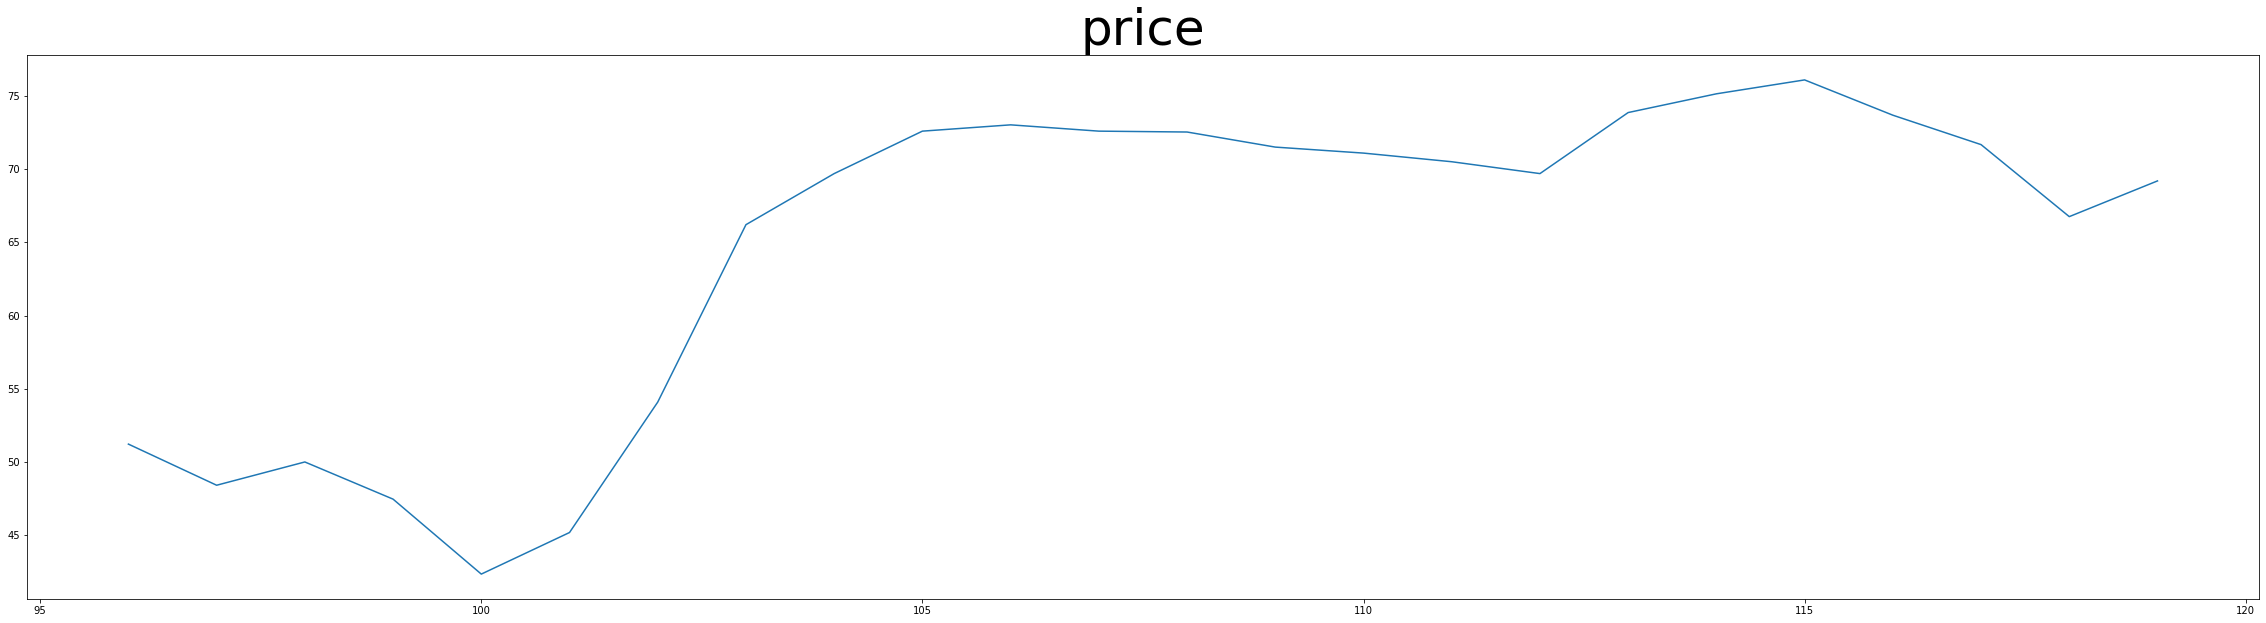

In [18]:
# zoom on a specific day (2017-01-05)

one_day = df_train[df_train['date']=="2017-01-05"]

for i in one_day.columns[:8]:
    plt.figure(figsize=(40,10))
    plt.plot(one_day[i])
    plt.title(i, fontsize=50)
    plt.show()

### Plotting the variable's distribution

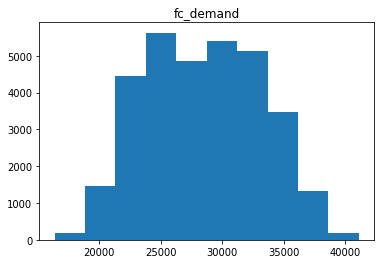

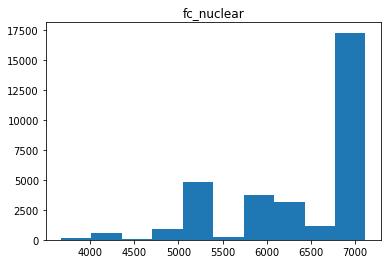

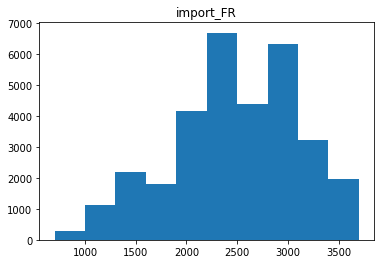

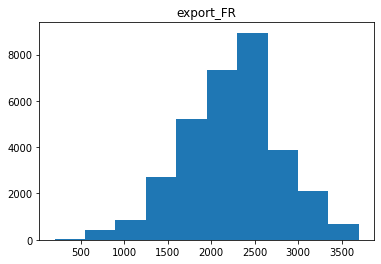

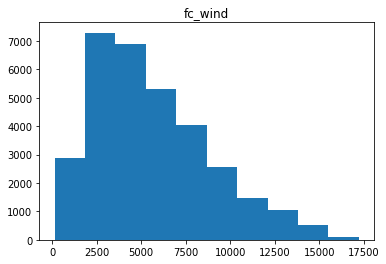

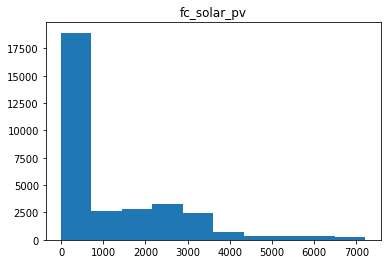

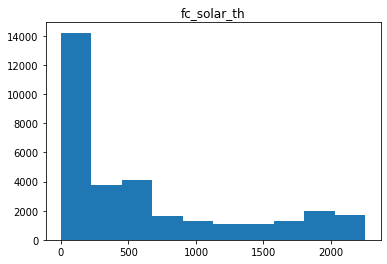

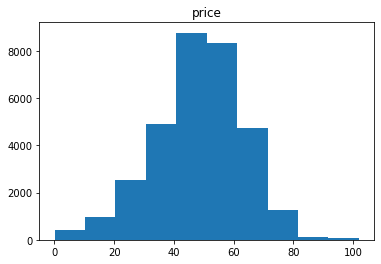

In [19]:
# distributions

for i in df_train.columns[:8]:
    plt.hist(df_train[i])
    plt.title(i)
    plt.show()

In [20]:
#price distribution, looks a little bit skewed. However, the transformation is not worth it since it makes it skewer

from scipy.stats import skew
skew(df_train['price'])

-0.35107530394068703

### Looking for outliers with boxplots

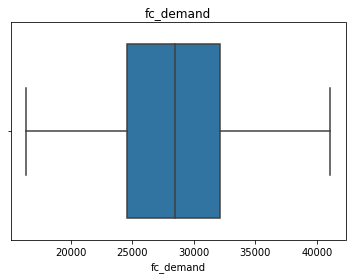

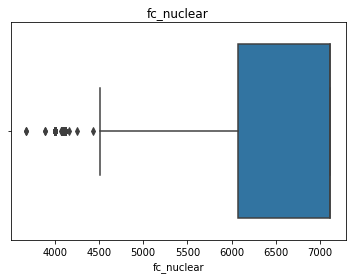

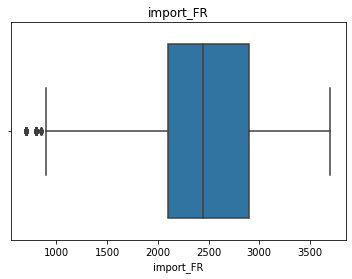

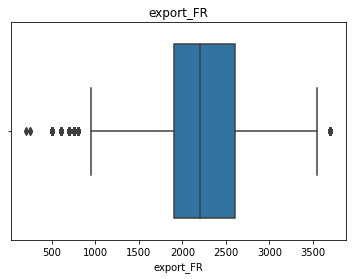

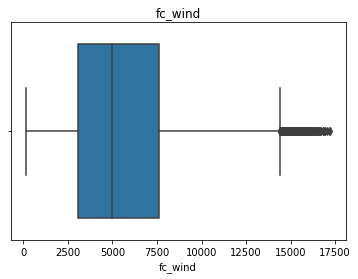

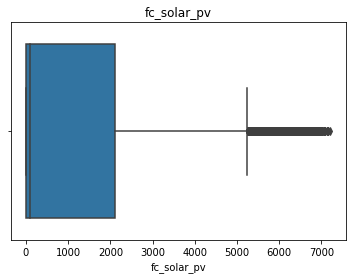

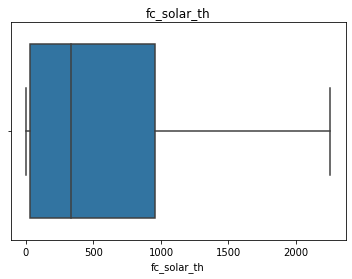

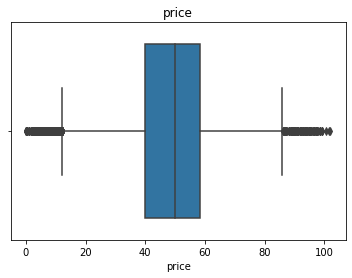

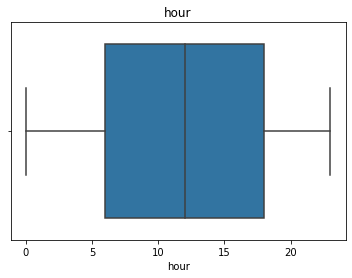

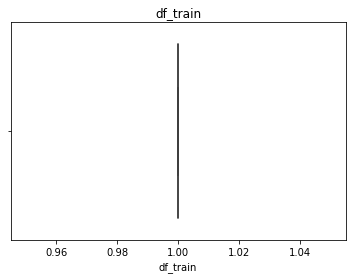

In [21]:
##Checking for outliers (possibly in fc_nuclear, import_Fr, export_FR, fc_wind, fc_solar_pv, price)

import seaborn as sns
for i in df_train[:]:
     if df_train[i].dtype in ['int64','float64']: # IS numeric
        sns.boxplot(x=df_train[i])
        plt.title(i)
        plt.show()

## Outlier detection

In [22]:
#Inputting nas in outliers

for x in [0,1,2,3,4,5,6,7]: # selecting only: fc_demand, fc_nuclear, import_FR, export_FR, fc_wind, fc_solar_pv, fc_solar_th
    q75,q25 = np.percentile(df_train.iloc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df_train.iloc[df_train.iloc[:,x] < min,x] = np.nan
    df_train.iloc[df_train.iloc[:,x] > max,x] = np.nan

df_train.isnull().sum()

/home/fcusimano/anaconda3/envs/ml2/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/fcusimano/anaconda3/envs/ml2/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/fcusimano/anaconda3/envs/ml2/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set 

fc_demand        0
fc_nuclear     728
import_FR      262
export_FR      539
fc_wind        347
fc_solar_pv    841
fc_solar_th      0
price          686
date             0
hour             0
df_train         0
date_time        0
dtype: int64

In [23]:
#Using a linear method to interpolate data for outliers
df_train['price'].interpolate(method='linear', inplace=True)
df_train["fc_nuclear"].interpolate(method='linear', inplace=True)
df_train["import_FR"].interpolate(method='linear', inplace=True)
df_train['export_FR'].interpolate(method='linear', inplace=True)
df_train["fc_wind"].interpolate(method='linear', inplace=True)
df_train["fc_solar_pv"].interpolate(method='linear', inplace=True)

df_train.isnull().sum()

<ipython-input-23-de0130fe41c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['price'].interpolate(method='linear', inplace=True)
<ipython-input-23-de0130fe41c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["fc_nuclear"].interpolate(method='linear', inplace=True)
<ipython-input-23-de0130fe41c1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["import_FR"].interpolate(method='linear', inplace=True)
<ipy

fc_demand      0
fc_nuclear     0
import_FR      0
export_FR      0
fc_wind        0
fc_solar_pv    0
fc_solar_th    0
price          0
date           0
hour           0
df_train       0
date_time      0
dtype: int64

## Timeseries analysis

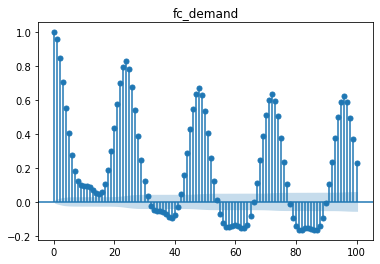

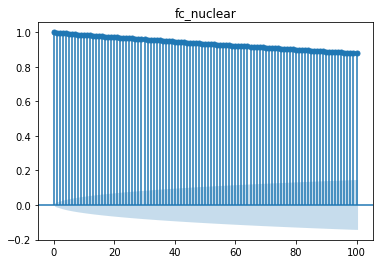

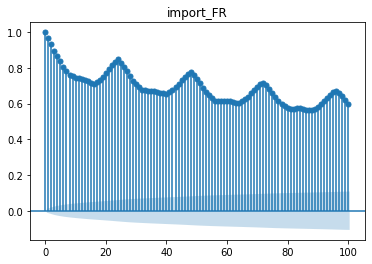

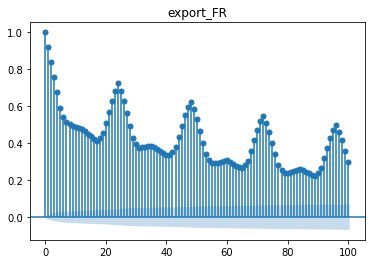

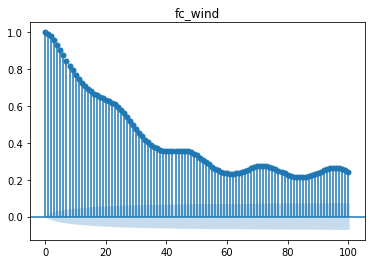

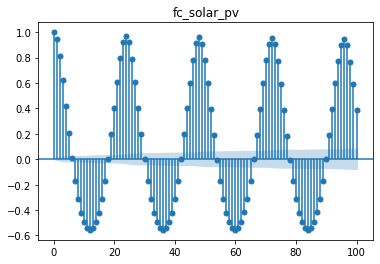

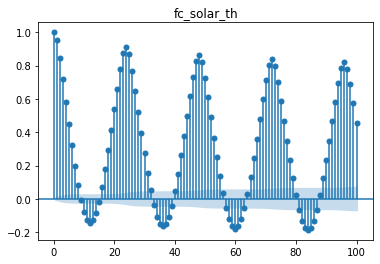

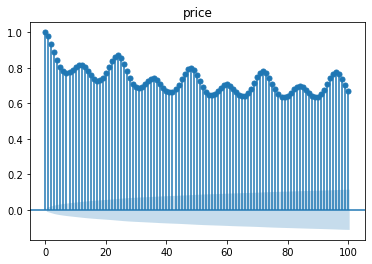

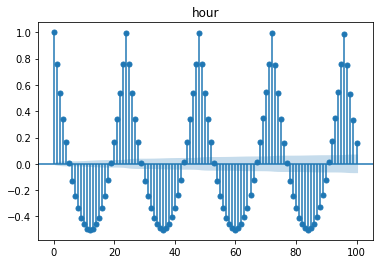

/home/fcusimano/anaconda3/envs/ml2/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/home/fcusimano/anaconda3/envs/ml2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


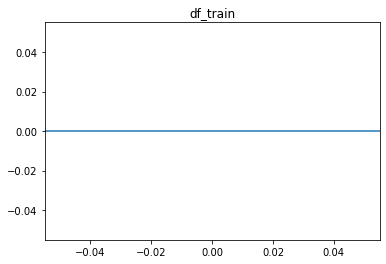

In [24]:
##checking for seasonality and autocorrelation

from statsmodels.graphics import tsaplots

for i in df_train[:7]:
     if df_train[i].dtype in ['int64','float64']: # IS numeric
        tsaplots.plot_acf(df_train[i], lags=100) # around 4 days
        plt.title(i)
        plt.show()

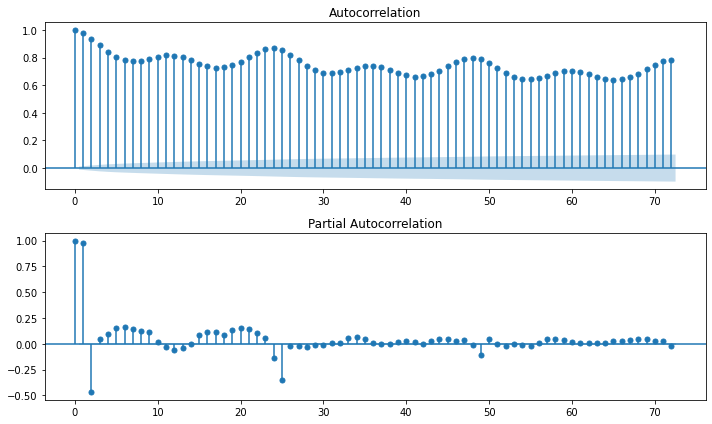

In [25]:
#partial autocorrelation price

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_train['price'], lags=72, ax=ax1)
plot_pacf(df_train['price'], lags=72, ax=ax2)
plt.tight_layout()
plt.show()
# t-1, t-2, t-3, t-24, t-25 are clearly out of bound and thus they can influence the price in t

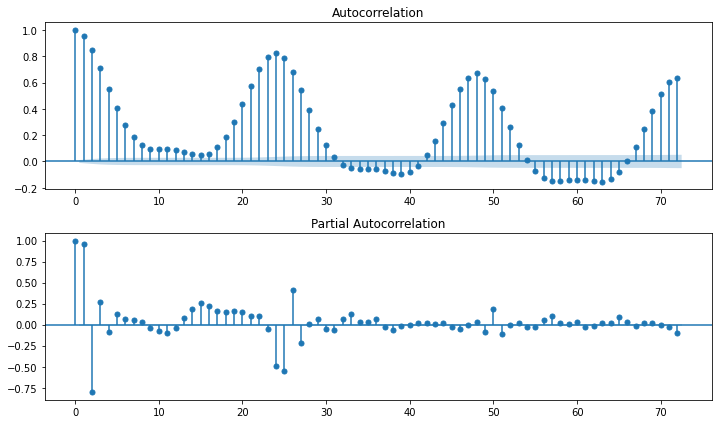

In [26]:
#partial autocorrelation demand

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_train['fc_demand'], lags=72, ax=ax1)
plot_pacf(df_train['fc_demand'], lags=72, ax=ax2)
plt.tight_layout()
plt.show()
# t-1, t-2, t-3, t-24, t-25 are clearly out of bound and thus they can influence the price in t

In [27]:
#checking for stationarity
from statsmodels.tsa.stattools import adfuller, kpss, ccf
y = df_train['price']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

#price is stationary, since H0 = tests for a presence of a unit root and clearly we can reject H0.

ADF Statistic: -6.926469
p-value: 0.000000
#Lags used: 51
Critical Value (1%): -3.430554
Critical Value (5%): -2.861630
Critical Value (10%): -2.566818


## Feature engineering

In [28]:
# re-combining both datasets into one for feature engineering

all_data = pd.concat([df_train,df_scoring])

In [29]:
# creating YEAR, MONTH, DAY variables
all_data['year'] = pd.DatetimeIndex(all_data['date']).year
all_data['month'] = pd.DatetimeIndex(all_data['date']).month
all_data['day'] = pd.DatetimeIndex(all_data['date']).dayofweek

# creating WEEKEND flag variable (1 = weekend, 0 = non weekend)
all_data["weekend"] = (all_data["day"] >= 5).astype(int)

# creating approximate night flag variable (1 = night, 0 = day)
all_data["night"] = ((all_data['hour'] > 23) | (all_data['hour'] < 8)).astype(int) 

# create dummy variable for COVID first 
all_data["covid"] = np.where((all_data['date_time'] >= "2020-03-15"), 1, 0)

# creating season variable (clever trick found of stack overflow)
all_data['season'] = (all_data['month']%12 + 3)//3
seasons = {
             1: 'Winter',
             2: 'Spring',
             3: 'Summer',
             4: 'Autumn'
}
all_data['season_name'] = all_data['season'].map(seasons)

#converting them into categorical
all_data['year'] = all_data.year.astype('category')
all_data['month'] = all_data.month.astype('category')
all_data['day'] = all_data.day.astype('category')
# all_data['weekend'] = all_data.weekend.astype('category')
# all_data['night'] = all_data.night.astype('category')
all_data['hour'] = all_data.hour.astype('int') # to remove decimal point
all_data['hour'] = all_data.hour.astype('category') # make it categorical
# all_data["covid"] =  all_data.covid.astype('category')
all_data["season_name"] =  all_data.season_name.astype('category')

# creating thermal_gap variable (demand minus nuclear, wind and solar production)
all_data["thermal_gap"] = all_data["fc_demand"] - (all_data["fc_nuclear"] + all_data["fc_wind"] + all_data["fc_solar_pv"] + all_data["fc_solar_th"])

# combining 2 solar productions types in 1
all_data['fc_solar_all'] = all_data['fc_solar_pv'] + all_data['fc_solar_th']

# creating delta of import export variable
all_data["delta_exp_imp_FR"] = all_data["export_FR"] - all_data["import_FR"]

# creating ratio variables
all_data["ratio_nuclear"] = all_data["fc_nuclear"] / all_data["fc_demand"]
all_data["ratio_thermal"] = all_data["thermal_gap"] / all_data["fc_demand"]
all_data["ratio_wind"] = all_data["fc_wind"] / all_data["fc_demand"]
all_data["ratio_solar"] = all_data["fc_solar_all"] / all_data["fc_demand"]

# printing categorical variables to make sure everything is in order
print('years:',all_data['year'].unique(),'\n\n',
      'months:',all_data['month'].unique(),'\n\n',
      'season_name:',all_data['season_name'].unique(),'\n\n',
      'days:',all_data['day'].unique(),'\n\n',
      'weekend:',all_data['weekend'].unique(),'\n\n',
      'night:',all_data['night'].unique(),'\n\n',
      'hour:',all_data['hour'].unique(),'\n\n')

years: [2017, 2018, 2019, 2020, 2021]
Categories (5, int64): [2017, 2018, 2019, 2020, 2021] 

 months: [1, 2, 3, 4, 5, ..., 8, 9, 10, 11, 12]
Length: 12
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12] 

 season_name: ['Winter', 'Spring', 'Summer', 'Autumn']
Categories (4, object): ['Winter', 'Spring', 'Summer', 'Autumn'] 

 days: [6, 0, 1, 2, 3, 4, 5]
Categories (7, int64): [6, 0, 1, 2, 3, 4, 5] 

 weekend: [1 0] 

 night: [1 0] 

 hour: [0, 1, 2, 3, 4, ..., 19, 20, 21, 22, 23]
Length: 24
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23] 




In [239]:
# create holiday feature with holidays-es package 

# DATES PASTED IN CODE BLOCK BELOW TO AVOID INSTALLING THE PACKAGE (no need to run this block)

# !pip install holidays-es #package that provides holidays in Spain by year
# !pip install bs4 #beatiful soup package required by holidays-es 

# from holidays_es import Province

# holidays = Province(name="valencia",year=(2017)).national_holidays()
# holidays.extend(Province(name="valencia",year=(2018)).national_holidays())
# holidays.extend(Province(name="valencia",year=(2019)).national_holidays())
# holidays.extend(Province(name="valencia",year=(2020)).national_holidays())
# holidays.extend(Province(name="valencia",year=(2021)).national_holidays())

In [30]:
import datetime

holidays = [
 datetime.date(2017, 1, 6), datetime.date(2017, 4, 14), datetime.date(2017, 5, 1),   datetime.date(2017, 8, 15),
 datetime.date(2017, 10, 12), datetime.date(2017, 11, 1), datetime.date(2017, 12, 6),  datetime.date(2017, 12, 8),
 datetime.date(2017, 12, 25), datetime.date(2018, 1, 1),  datetime.date(2018, 1, 6),   datetime.date(2018, 3, 30),
 datetime.date(2018, 5, 1),   datetime.date(2018, 8, 15), datetime.date(2018, 10, 12), datetime.date(2018, 11, 1),
 datetime.date(2018, 12, 6),  datetime.date(2018, 12, 8), datetime.date(2018, 12, 25), datetime.date(2019, 1, 1),
 datetime.date(2019, 4, 19),  datetime.date(2019, 5, 1), datetime.date(2019, 8, 15),  datetime.date(2019, 10, 12),
 datetime.date(2019, 11, 1),  datetime.date(2019, 12, 6), datetime.date(2019, 12, 25), datetime.date(2020, 1, 1),
 datetime.date(2020, 1, 6),   datetime.date(2020, 4, 10), datetime.date(2020, 5, 1),   datetime.date(2020, 8, 15),
 datetime.date(2020, 10, 12), datetime.date(2020, 12, 8), datetime.date(2020, 12, 25), datetime.date(2021, 1, 1),
 datetime.date(2021, 1, 6),   datetime.date(2021, 4, 2), datetime.date(2021, 10, 12), datetime.date(2021, 11, 1),
 datetime.date(2021, 12, 6),  datetime.date(2021, 12, 8), datetime.date(2021, 12, 25)
]

In [31]:
# Creating holiday dummy variable

all_data['holiday'] = all_data.date.isin(holidays).astype(int)

In [32]:
# Dummifying the categorical variables

# day of week
all_data = pd.concat([all_data,pd.get_dummies(all_data['day'],drop_first=True,prefix='day')],axis=1)\
                    .drop(['day'],axis=1)

# month
all_data = pd.concat([all_data,pd.get_dummies(all_data['month'],drop_first=True,prefix='month')],axis=1)\
                    .drop(['month'],axis=1)

# seasons
all_data = pd.concat([all_data,pd.get_dummies(all_data['season_name'],drop_first=True)],axis=1)\
                    .drop(['season_name'],axis=1)

In [33]:
# removing redundant or not relevant features:

all_data = all_data.drop(columns =['fc_solar_pv', 'fc_solar_th', 'export_FR', 'import_FR']) 

In [34]:
# features that will be used:
all_data.columns

Index(['fc_demand', 'fc_nuclear', 'fc_wind', 'price', 'date', 'hour',
       'df_train', 'date_time', 'year', 'weekend', 'night', 'covid', 'season',
       'thermal_gap', 'fc_solar_all', 'delta_exp_imp_FR', 'ratio_nuclear',
       'ratio_thermal', 'ratio_wind', 'ratio_solar', 'holiday', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'Spring', 'Summer', 'Winter'],
      dtype='object')

Text(0.5, 1.0, 'Pre vs. post Covid')

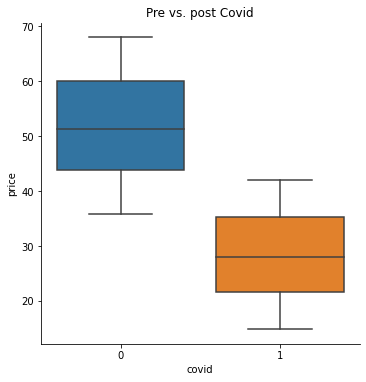

In [36]:
ax = sns.catplot(y='price',
            x='covid',
            kind='box',
            sym='', # Hide outliers !!!!
            whis=0.5, # 0.5*IQR Proportion of the IQR past the low and high quartiles to extend the plot whiskers
            data=all_data,
           )

plt.title('Pre vs. post Covid')

## Modeling

### selecting features

In [37]:
var_list = ['date_time','price','df_train']

initial_df = all_data[list(var_list)]

In [38]:
initial_df.head()

date_time  price  df_train
0 2017-01-01 00:00:00  58.82         1
1 2017-01-01 01:00:00  58.23         1
2 2017-01-01 02:00:00  51.95         1
3 2017-01-01 03:00:00  47.27         1
4 2017-01-01 04:00:00  45.49         1

In [39]:
# scaling the data OPTIONAL

# from sklearn.preprocessing import StandardScaler

# X = final_df.iloc[:,0:2].values # We do not take `df_train_test`
# final_df.iloc[:,0:2] = StandardScaler().fit_transform(X) # normalizing the features


### splitting datasets

In [40]:
# split all_data back into df_train and df_scoring and removing `df_train_test` column
# spliting all_data to plot df_train on last time

df = initial_df[initial_df.loc[:,'df_train',] == 1].drop('df_train', axis=1)
df_scoring = initial_df[initial_df.loc[:,'df_train'] == 0].drop('df_train', axis=1)

# NAIVE MODELS

In [41]:
# Installing sktime required through the following command:

# !pip install git+https://github.com/alan-turing-institute/sktime

In [42]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

In [44]:
df_1 = df.copy()

In [45]:
df_1 = df_1.set_index('date_time') # set date_time as the index
df_1 = df_1.iloc[:,0] # converting to pd.Series dtype
df_1 = df_1.to_period('H') # set series frequency to hourly (H)

In [46]:
df_1

date_time
2017-01-01 00:00    58.82
2017-01-01 01:00    58.23
2017-01-01 02:00    51.95
2017-01-01 03:00    47.27
2017-01-01 04:00    45.49
                    ...  
2020-08-31 19:00    47.88
2020-08-31 20:00    51.18
2020-08-31 21:00    55.69
2020-08-31 22:00    50.77
2020-08-31 23:00    45.00
Freq: H, Name: price, Length: 32125, dtype: float64

22487 9638


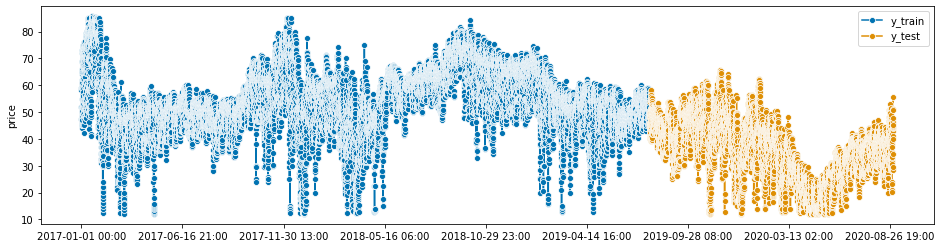

In [47]:
# splitting data into train and test period (using 70% / 30% split)

train, test = temporal_train_test_split(df_1, test_size= int(df_1.shape[0]) -int(df_1.shape[0]*0.7) )
plot_series(train, test, labels=["y_train", "y_test"])
print(train.shape[0], test.shape[0])

## Naive model 1: Predicting with the last value 

In [48]:
# selecting the forecasting horizon, in this case the entire test period

fh = ForecastingHorizon(test.index, is_relative=False)

RMSE = 13.7572


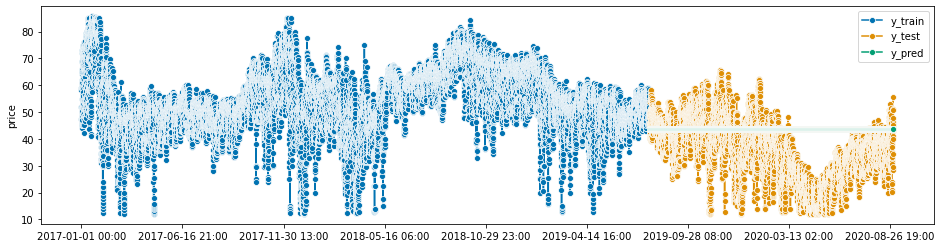

In [49]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# predicting last value
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(train)
y_pred = forecaster.predict(fh)
plot_series(train, test, y_pred, labels=["y_train", "y_test", "y_pred"])

print("RMSE = {0:.4f}".format(np.sqrt(mean_squared_error(test, y_pred))))

## Naive model 2: Predicting with the last year's values 

RMSE = 24.5843


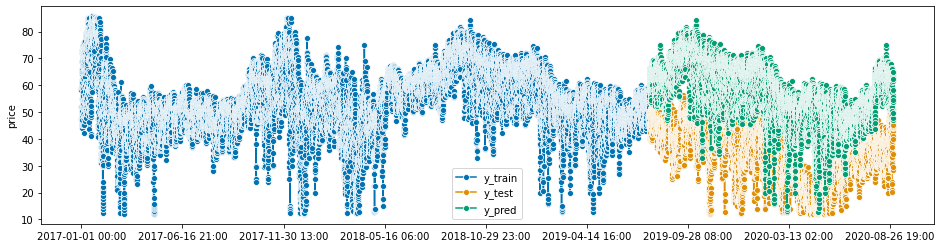

In [50]:
# Predicting the last value of the same season
forecaster = NaiveForecaster(strategy="last", sp=8928) # 24*31*12
forecaster.fit(train)
y_pred = forecaster.predict(fh)
plot_series(train, test, y_pred, labels=["y_train", "y_test", "y_pred"])

print("RMSE = {0:.4f}".format(np.sqrt(mean_squared_error(test, y_pred))))

# Non naive models with other features
## Selecting features to use

In [51]:
# create lag variables for fc_demand

all_data['fc_demand_lag1'] = all_data['fc_demand'].shift(1) # 1 hour lag
all_data['fc_demand_lag2'] = all_data['fc_demand'].shift(2) # 2 hour lag
all_data['fc_demand_lag3'] = all_data['fc_demand'].shift(3) # 3 hour lag
all_data['fc_demand_lag24'] = all_data['fc_demand'].shift(24) # 24 hour lag


In [52]:
all_data.columns

Index(['fc_demand', 'fc_nuclear', 'fc_wind', 'price', 'date', 'hour',
       'df_train', 'date_time', 'year', 'weekend', 'night', 'covid', 'season',
       'thermal_gap', 'fc_solar_all', 'delta_exp_imp_FR', 'ratio_nuclear',
       'ratio_thermal', 'ratio_wind', 'ratio_solar', 'holiday', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'Spring', 'Summer', 'Winter',
       'fc_demand_lag1', 'fc_demand_lag2', 'fc_demand_lag3',
       'fc_demand_lag24'],
      dtype='object')

In [102]:
# select variables to keep


var_list = ['fc_demand', 'price','fc_nuclear', 'fc_wind',
       'df_train','night', 'covid', 'weekend','hour',
       'delta_exp_imp_FR','thermal_gap', 'fc_solar_all',
       'holiday', 'Spring', 'Summer', 'Winter', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'fc_demand_lag1', 'fc_demand_lag2',
       'fc_demand_lag3', 'fc_demand_lag24']

initial_df = all_data[list(var_list)]

# separating the scoring dataset from the rest of the data:

df_train = initial_df[initial_df.loc[:,'df_train',] == 1].drop('df_train', axis=1)
df_scoring = initial_df[initial_df.loc[:,'df_train'] == 0].drop('df_train', axis=1)


In [103]:
# splitting df_train into target (y) and explanatory variables (X)
df_train = df_train.dropna()

X = df_train.loc[:, df_train.columns != 'price']
y = df_train['price']

## Linear regression

We will use a simple linear regression as our first model. As we are dealing with timeseries data, we cannot use random splitting techniques to split the data into train and test sets as this would result in partly using data from the future to predict past values. 

Instead, we will use the function TimeSeriesSplit from sklearn which uses walk forward validation allowing us to divide the data into multiple chunks while respecting the unidirectionality of time. However, we found that different number of splits have a impact on model performance, and for this reason we perform a grid search to find the optimal number of split for the model.


In [56]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

regression = linear_model.LinearRegression()

RMSE = []
n_of_splits = []


for splits in range(2,30): # testing between 2 and 100 splits
    n_splits = splits
    tscv = TimeSeriesSplit(n_splits)
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    regression.fit(X_train, y_train)
    predictions = regression.predict(X_test)
    RMSE.append(np.sqrt(mean_squared_error(y_test, predictions)))
    n_of_splits.append(splits)
    split_df = pd.DataFrame({'n_of_splits':n_of_splits,'RMSE':RMSE})
print('Optimal number of splits found:')
split_df[split_df['RMSE'] == split_df['RMSE'].min()]

Optimal number of splits found:


n_of_splits      RMSE
7            9  5.857158

## Ridge regression

In [57]:
ridge = linear_model.Ridge()

n_splits = 13
tscv = TimeSeriesSplit(n_splits)

# find optimal alpha with grid search
from sklearn.model_selection import GridSearchCV
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000,]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, cv=tscv)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 13 folds for each of 7 candidates, totalling 91 fits
Best Score:  -110.98535326453943
Best Params:  {'alpha': 100}


In [58]:
# using best alpha

ridge = linear_model.Ridge(alpha = 1000)

RMSE = []
n_of_splits = []

for splits in range(2,30):
    n_splits = splits
    tscv = TimeSeriesSplit(n_splits)
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    ridge.fit(X_train, y_train)
    predictions = ridge.predict(X_test)
    RMSE.append(np.sqrt(mean_squared_error(y_test, predictions)))
    n_of_splits.append(splits)
    split_df = pd.DataFrame({'n_of_splits':n_of_splits,'RMSE':RMSE})
print('Optimal number of splits found:')
split_df[split_df['RMSE'] == split_df['RMSE'].min()]

Optimal number of splits found:


n_of_splits      RMSE
11           13  4.699881

# TREES

## Single tree to find the optimal number of splits

In [62]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=6)

RMSE = []
n_of_splits = []

for splits in range(2,30):
    n_splits = splits
    tscv = TimeSeriesSplit(n_splits)
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    tree.fit(X_train, y_train)
    predictions = tree.predict(X_test)
    RMSE.append(np.sqrt(mean_squared_error(y_test, predictions)))
    n_of_splits.append(splits)
    split_df = pd.DataFrame({'n_of_splits':n_of_splits,'RMSE':RMSE})
print('Optimal number of splits found:')
split_df[split_df['RMSE'] == split_df['RMSE'].min()]

Optimal number of splits found:


n_of_splits      RMSE
3           28  4.520879

## Bagging

In [153]:
bagged_trees = RandomForestRegressor(random_state=42, n_estimators=600, max_depth= 7, max_features=len(X_train.columns))


n_splits = 28
tscv = TimeSeriesSplit(n_splits)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

bagged_trees.fit(X_train, y_train)
predictions = bagged_trees.predict(X_test)

print("RMSE = {0:.4f}".format(np.sqrt(mean_squared_error(y_test, predictions))))

RMSE = 4.4311


## Random forest

In [105]:
trees = RandomForestRegressor(random_state=42, n_estimators=600, max_depth= 7, max_features=7)

trees.fit(X_train, y_train)
predictions = trees.predict(X_test)

print("RMSE = {0:.4f}".format(np.sqrt(mean_squared_error(y_test, predictions))))

RMSE = 3.8412


## XGBoost

In [74]:
# we need to 'dummify' hour for XGBoost (we did not do it before to avoid having too many variables)

X = pd.concat([X,pd.get_dummies(X['hour'],drop_first=True,prefix='hour')],axis=1)\
                    .drop(['hour'],axis=1)

In [77]:
# default parameters

import xgboost

n_splits = 28
tscv = TimeSeriesSplit(n_splits)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

xgb_tree = xgboost.XGBRegressor(objective="reg:squarederror")
xgb_tree.fit(X_train, y_train)
predictions = xgb_tree.predict(X_test)
print("RMSE = {0:.4f}".format(np.sqrt(mean_squared_error(y_test, predictions))))

RMSE = 4.7262


In [241]:
# grid search (unfortunately too computively intensive, it takes us 1h45 to run with n_iter=1)

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

n_splits = 27
tscv = TimeSeriesSplit(n_splits)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(5, 8), # default 3
    "n_estimators": randint(450, 650) # default 100
#     "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_tree, param_distributions=params, random_state=42, n_iter=1, cv=tscv, verbose=1, n_jobs=4, return_train_score=True)
search.fit(X_train, y_train)

Fitting 27 folds for each of 1 candidates, totalling 27 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=27, test_size=None),
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, mis...
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa3edbcb4f0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa421cd2d30>,
                        

In [248]:
print("Best parameters set found on development set:\n")
print(search.best_params_)
predictions = search.best_estimator_.predict(X_test)
print("RMSE = {0:.4f}".format(np.sqrt(mean_squared_error(y_test, predictions))))

Best parameters set found on development set:

{'colsample_bytree': 0.8123620356542087, 'gamma': 0.4753571532049581, 'learning_rate': 0.24959818254342153, 'max_depth': 5, 'n_estimators': 470}
RMSE = 5.3225


In [78]:
# testing a few different parameters manually
xgb_tree = xgboost.XGBRegressor(objective="reg:squarederror",
                                colsample_bytree=0.4,
                                gamma=0.3, 
                                learning_rate=0.007,
                                subsample = 0.75,
                                max_depth=7,
                                n_estimators=600)

xgb_tree.fit(X_train, y_train)
predictions = xgb_tree.predict(X_test)
print("RMSE = {0:.4f}".format(np.sqrt(mean_squared_error(y_test, predictions))))

RMSE = 4.0573


# Submission

In [121]:
# using the model with the lowest RMSE: random forest (trees)

X_scoring = df_scoring.loc[:, df_train.columns != 'price']
final_predictions = trees.predict(X_scoring)

In [125]:
final_predictions=pd.DataFrame(final_predictions, columns=['price']) 
final_predictions

price
0     36.620359
1     34.983824
2     34.294360
3     34.197751
4     34.734567
...         ...
3664  28.228331
3665  29.527802
3666  29.867565
3667  29.059775
3668  26.326414

[3669 rows x 1 columns]

In [147]:
# exporting as csv file

final_predictions.to_csv(r'prediction.csv')

# Further experimentation...
## Single layer neural network using price lag variable

In [111]:
# Using the tensorflow package
# !pip install tensorflow

In [33]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [149]:
df_2 = df.copy()
df_2 = df_2.drop(['date_time'],axis=1)
df_2 = df_2.iloc[:,0] # converting to pd.Series dtype

In [609]:
df_2.head()

date_time
2017-01-01 00:00   58.82
2017-01-01 01:00   58.23
2017-01-01 02:00   51.95
2017-01-01 03:00   47.27
2017-01-01 04:00   45.49
Freq: H, Name: price, dtype: float64

training timeseries:


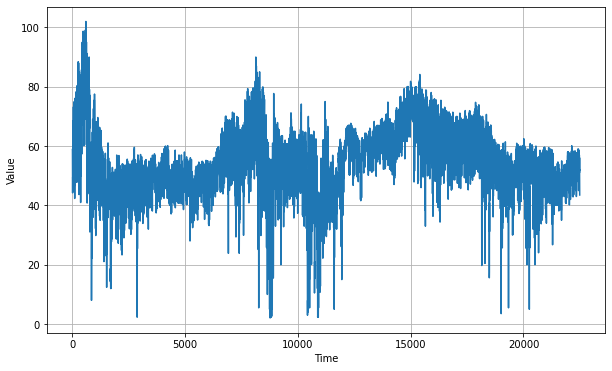

validation timeseries:


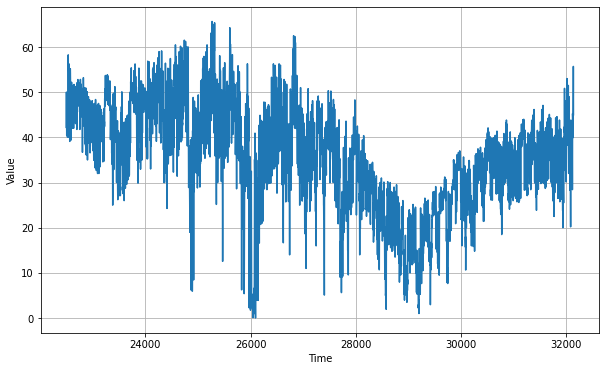

In [454]:
# splitting data into train and validation

time=df_2.index
series=df_2.values

split_time = 22487
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

print('training timeseries:')
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

print('validation timeseries:')
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [35]:
# Function to apply our model recursively, using predicted prices to forecast the following prices.
# source: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb#scrollTo=4sTTIOCbyShY

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [440]:
window_size = 24 # each window corresponds to 1 day (24h)
batch_size = 32
shuffle_buffer_size = 1000

In [441]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

# we can see the coefficients for each lag hour.

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Layer weights [array([[-0.15409961],
       [ 0.23960492],
       [-0.01126483],
       [ 0.01654736],
       [ 0.01309688],
       [-0.03782021],
       [-0.01152852],
       [ 0.06428201],
       [-0.02260173],
       [ 0.01490645],
       [-0.10525697],
       [ 0.05909481],
       [-0.0680635 ],
       [ 0.08395477],
       [-0.06380485],
       [ 0.1594442 ],
       [-0.13610293],
       [ 0.11648201],
       [-0.04078264],
       [-0.02485207],
       [ 0.0349834 ],
       [-0.09475511],
       [-0.26880464],
       [ 1.2369677 ]], dtype=float32), array([0.03561034], dtype=float32)]


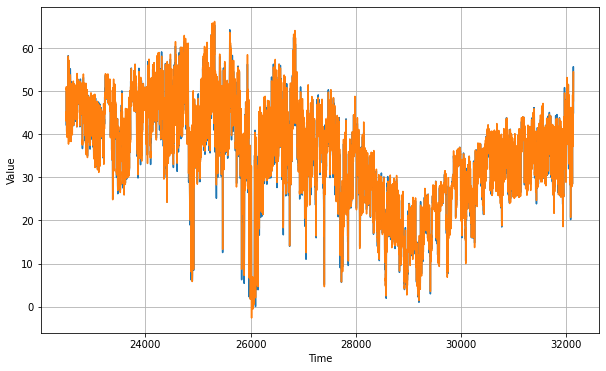

In [442]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [443]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.4840858

In [ ]:
# corresponds to a RMSE of 1.21823